# Analyse Exploratoire du jeu de Données `OpenFoodFacts`
*Les liens ne fonctionnent pas lorsque le notebook est affiché sur **Github**. Donc vous souhaitez visualiser ce notebook en ligne avec les liens menu actifs, vous pouvez le faire à cette adresse: https://nbviewer.org/github/Valkea/OC_AI_03/blob/main/Cleaning_Nutrigrade.ipynb )*

* [1. Objectif du projet](#P01)
* [2. Présentation générale du jeu de données](#P02)
* [3. Identification des colonnes utiles](#P03)
* [4. Démarche méthodologique d’analyse de données](#P04)
    * [Analyses univariées & suppression des valeurs aberrantes](#P04_univariate)
    * [Analyses multivariées](#P04_multivariate)
* [5. Nettoyage des données](#P05)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

# Objectif  <a class="anchor" id="P01"></a>

Le Nutri-grade est une information qui peut être utile pour comparer divers produits d'une même catégorie les uns avec les autres. Cependant, tous les produits ne disposent pas de cette information et il pourrait être intéressant de pouvoir calculer ce grade à partir des indications disponibles sur les étiquettes des produits (ou même simplement en scannant le code-barre).

**Nous allons donc essayer de calculer le nutri-grade en nous basant sur les données disponibles sur l'étiquette d'un produit.**

En cherchant sur le site https://www.santepubliquefrance.fr on peut trouver des [informations](https://www.santepubliquefrance.fr/content/download/150262/file/QR_scientifique_technique_310322.pdf) (page 30) nous permettant de déterminer les éléments favorables ou défavorables au calcul de ce grade.

#### Éléments défavorables au score

- Apport calorique pour cent grammes.
- Teneur en sucre.
- Teneur en graisses saturées.
- Teneur en sel.

#### Éléments favorables au score

- Teneur en fruits, légumes, légumineuses (dont les légumes secs), oléagineux, huiles de colza, de noix et d'olive.
- Teneur en fibres.
- Teneur en protéines.

Pour calculer la teneur de fruits et légumes, les féculents (tel que pomme de terre, patate douce, taro, manioc et tapioca) ne sont pas pris en compte.

Pour les fromages, la teneur en protéines est toujours prise en compte car celle-ci est liée à celle en calcium. Ceci améliore le nutri-score des fromages et la cohérence entre celui-ci et les recommandations nutritionnelles du Haut Conseil de la Santé Publique. Celles-ci recommandent en effet de consommer des produits laitiers plusieurs fois par jour. 

# 2. Présentation générale du jeu de données <a class="anchor" id="P02"></a>

Le [jeu de données](https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv) utilisé dans le cadre de l'appel à projets de l'agence *Santé publique France* qui consiste à rendre les données de santé plus accessibles, est une liste de 2.251.894 produits alimentaires répertoriés par les volontaires de l'association [Open Food Facts](https://world.openfoodfacts.org).

Chacun des produits référencé est décrit par un certain nombre de caractèristiques nutritionels *(taux de graisse, de sucre, de sel, de fibres, de protéines, de vitamines, etc.)* et par des méta-données *(code-barre, nom du produit, catégorie, lieu de production, data d'ajout dans la DB, auteur de l'ajout, etc.)*.

> Le jeu de données complet fait plus de 5.9GB. Et il est difficile de travailler avec un tel volume de donnée,<br> donc **nous avons crée un jeu de données réduit (dans Cleaning_01.ipynb) que nous allons utiliser ici**.

#### Commençons par charger les colonnes choisies (et leur dtype) dans le premier notebook

In [2]:
filename = 'data/dtypes_low.csv'

In [3]:
dtypes_df = pd.read_csv(filename, sep=',', index_col=0)

In [4]:
cols_to_keep = dtypes_df.columns
dtypes = dtypes_df.to_dict('records')[0]

#### Puis chargeons le jeu de données réduit

In [5]:
cols_to_keep

Index(['sugars_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g',
       'code', 'iron_100g', 'pnns_groups_2', 'energy_100g', 'cholesterol_100g',
       'saturated-fat_100g', 'additives_n', 'salt_100g', 'serving_quantity',
       'vitamin-a_100g', 'labels_tags', 'trans-fat_100g', 'vitamin-c_100g',
       'nutriscore_grade', 'product_name', 'states_tags', 'serving_size',
       'fiber_100g', 'calcium_100g', 'sodium_100g', 'url',
       'carbohydrates_100g', 'traces_tags', 'nova_group', 'proteins_100g',
       'pnns_groups_1', 'nutriscore_score', 'allergens', 'quantity',
       'additives_tags', 'ingredients_tags', 'main_category', 'fat_100g',
       'categories_tags'],
      dtype='object')

In [6]:
filename = 'data/en.openfoodfacts.org.products.csv'

In [7]:
data = pd.read_csv(filename, sep='\t', dtype=dtypes, usecols=cols_to_keep)

### Explorons le jeu de données reduit

In [8]:
data.head(3)

code                                                url  \
0     00000000000000225  http://world-en.openfoodfacts.org/product/0000...   
1  00000000000003429145  http://world-en.openfoodfacts.org/product/0000...   
2         0000000000017  http://world-en.openfoodfacts.org/product/0000...   

       product_name quantity categories_tags labels_tags  \
0    jeunes pousses      NaN             NaN         NaN   
1           L.casei      NaN             NaN         NaN   
2  Vitória crackers      NaN             NaN         NaN   

                                    ingredients_tags allergens traces_tags  \
0                                                NaN       NaN         NaN   
1  en:semi-skimmed-milk,en:dairy,en:milk,es:azuca...       NaN         NaN   
2                                                NaN       NaN         NaN   

  serving_size  ...  sugars_100g  fiber_100g proteins_100g  salt_100g  \
0          NaN  ...          NaN         NaN           NaN        NaN   
1          NaN  ...          9.8         NaN           2.7        0.1   
2          NaN  ...         15.0         NaN           7.8        1.4   

  sodium_100g vitamin-a_100g vitamin-c_100g calcium_100g iron_100g  \
0         NaN            NaN            NaN          NaN       NaN   
1        0.04            NaN            NaN          NaN       NaN   
2        0.56            NaN            NaN          NaN       NaN   

  fruits-vegetables-nuts-estimate-from-ingredients_100g  
0                                                NaN     
1                                                0.0     
2                                                NaN     

[3 rows x 36 columns]

> En voyant tous les `NaN` ci-dessus *(et retroactivement pour faciliter les analyses, car ils ne tons pas tous comptés comme None)*, nous allons remplacer les valeurs neutres par des `None`.

#### Remplaçons les diverses instances de types NaN ou équivalents par None

In [9]:
fill_rate_before = data.notnull().mean(axis=0)

In [10]:
for cat in data.select_dtypes(exclude=np.number).columns:
    data[cat].replace(['unknown',np.NaN, "NaN"], None, inplace=True)

In [11]:
fill_rate_after = data.notnull().mean(axis=0)

In [12]:
for n, f1, f2 in zip(fill_rate_before.index, fill_rate_before, fill_rate_after):
    print(f"{n.rjust(55)}\tAVANT:{100.0*f1:6.2f}% \tAPRES:{100.0*f2:6.2f}% \t[{100.0*(f2-f1):8.4f}%]")

                                                   code	AVANT:100.00% 	APRES:100.00% 	[  0.0000%]
                                                    url	AVANT:100.00% 	APRES:100.00% 	[  0.0000%]
                                           product_name	AVANT: 96.19% 	APRES: 96.19% 	[ -0.0001%]
                                               quantity	AVANT: 25.59% 	APRES: 25.59% 	[  0.0000%]
                                        categories_tags	AVANT: 44.90% 	APRES: 44.90% 	[  0.0000%]
                                            labels_tags	AVANT: 20.52% 	APRES: 20.52% 	[  0.0000%]
                                       ingredients_tags	AVANT: 33.46% 	APRES: 33.46% 	[  0.0000%]
                                              allergens	AVANT:  8.85% 	APRES:  8.85% 	[  0.0000%]
                                            traces_tags	AVANT:  6.06% 	APRES:  6.06% 	[  0.0000%]
                                           serving_size	AVANT: 23.57% 	APRES: 23.57% 	[  0.0000%]
                    

In [13]:
data.head(3)

code                                                url  \
0     00000000000000225  http://world-en.openfoodfacts.org/product/0000...   
1  00000000000003429145  http://world-en.openfoodfacts.org/product/0000...   
2         0000000000017  http://world-en.openfoodfacts.org/product/0000...   

       product_name quantity categories_tags labels_tags  \
0    jeunes pousses     None            None        None   
1           L.casei     None            None        None   
2  Vitória crackers     None            None        None   

                                    ingredients_tags allergens traces_tags  \
0                                               None      None        None   
1  en:semi-skimmed-milk,en:dairy,en:milk,es:azuca...      None        None   
2                                               None      None        None   

  serving_size  ...  sugars_100g  fiber_100g proteins_100g  salt_100g  \
0         None  ...          NaN         NaN           NaN        NaN   
1         None  ...          9.8         NaN           2.7        0.1   
2         None  ...         15.0         NaN           7.8        1.4   

  sodium_100g vitamin-a_100g vitamin-c_100g calcium_100g iron_100g  \
0         NaN            NaN            NaN          NaN       NaN   
1        0.04            NaN            NaN          NaN       NaN   
2        0.56            NaN            NaN          NaN       NaN   

  fruits-vegetables-nuts-estimate-from-ingredients_100g  
0                                                NaN     
1                                                0.0     
2                                                NaN     

[3 rows x 36 columns]

Et reprenons l'exploration des données

In [14]:
data.shape

(2251894, 36)

In [15]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [16]:
data.describe().T

count  \
serving_quantity                                    526776.000   
additives_n                                         755169.000   
nutriscore_score                                    776383.000   
energy_100g                                        1786722.000   
fat_100g                                           1777186.000   
saturated-fat_100g                                 1731439.000   
trans-fat_100g                                      265364.000   
cholesterol_100g                                    269384.000   
carbohydrates_100g                                 1776746.000   
sugars_100g                                        1758313.000   
fiber_100g                                          639994.000   
proteins_100g                                      1778610.000   
salt_100g                                          1640254.000   
sodium_100g                                        1640251.000   
vitamin-a_100g                                      212955.000   
vitamin-c_100g                                      220782.000   
calcium_100g                                        271880.000   
iron_100g                                           265735.000   
fruits-vegetables-nuts-estimate-from-ingredient...  753817.000   

                                                                                             mean  \
serving_quantity                                                            21092745435793836.000   
additives_n                                                                                 2.013   
nutriscore_score                                                                            9.091   
energy_100g                                             3730607721228534090965745911682039808.000   
fat_100g                                                                         562754208033.989   
saturated-fat_100g                                                                      57722.281   
trans-fat_100g                                                                              0.162   
cholesterol_100g                                                                            0.060   
carbohydrates_100g                                                                      56274.039   
sugars_100g                                                                          56929545.382   
fiber_100g                                         153333860029341582185095018443795150667776.000   
proteins_100g                                                                           56198.842   
salt_100g                                                                               60928.005   
sodium_100g                                                                             24371.247   
vitamin-a_100g                                                                              1.671   
vitamin-c_100g                                                                              0.114   
calcium_100g                                                                              736.131   
iron_100g                                                                                   0.038   
fruits-vegetables-nuts-estimate-from-ingredient...                                          8.602   

                                                                                                 std  \
serving_quantity                                                            15308918127999203328.000   
additives_n                                                                                    2.880   
nutriscore_score                                                                               8.849   
energy_100g                                             4986640698625920150338062244302641168384.000   
fat_100g                                                                         750124863814886.500   
saturated-fat_100g                                                                      759

> On remarque que beaucoup de colonnes numériques ont des valeurs `min`, `max` *(et donc `mean` et `std`)* clairement hors normes.
>
> Il va falloir s'occuper de toutes ces valeurs aberrantes.
---

In [17]:
data.describe(exclude="number").T

count   unique  \
code              2251894  2251873   
url               2251894  2251876   
product_name      2166178  1387468   
quantity           576236    39373   
categories_tags   1011088    79235   
labels_tags        462090    64122   
ingredients_tags   753418   569887   
allergens          199182     7300   
traces_tags        136399    13774   
serving_size       530697    47576   
additives_tags     434228   103551   
nutriscore_grade   776383        5   
nova_group         679561        4   
pnns_groups_1      816330       11   
pnns_groups_2      816332       41   
states_tags       2251894     4795   
main_category     1011088    35204   

                                                                top    freq  
code                                                  3477610001135       2  
url               http://world-en.openfoodfacts.org/product/3477...       2  
product_name                                                   Miel    1449  
quantity                                                      500 g   24211  
categories_tags                                           en:snacks   34325  
labels_tags                                              en:organic   47495  
ingredients_tags  en:extra-virgin-olive-oil,en:oil-and-fat,en:ve...    1391  
allergens                                                   en:milk   42134  
traces_tags                                                 en:nuts   13203  
serving_size                                                   100g   24366  
additives_tags                                              en:e330   26240  
nutriscore_grade                                                  d  240061  
nova_group                                                        4  440248  
pnns_groups_1                                         Sugary snacks  169128  
pnns_groups_2                                                Sweets   76620  
states_tags       en:to-be-completed,en:nutrition-facts-complete...  389036  
main_category                                             en:snacks   34348

> Sur la base des colonnes `code` et `url` *(sensées être uniques)*, on remarque qu'il y a au moins un doublon. Il faudra donc le(s) supprimer.
---

#### Affichons les taux de valeurs manquantes pour chaque colonne.

In [18]:
# Définissons une fonction qui nous permet d'afficher 
# facilement le nombre de valeurs manquantes / présentes et leur taux

def print_fill_rate(dataset, col_array):
    fill_count = dataset[col_array].notnull().sum()
    fill_ratio = fill_count/dataset.shape[0]*100.0
    
    total = dataset.shape[0]
    max_size = max([len(x) for x in dataset.columns])
    
    for k, v in zip(fill_count.keys(), fill_count):
        fraction = v/dataset.shape[0]*100.0
        print(f"{k.rjust(max_size)} | {total-v:8} lignes vides | remplissage: {fraction:6.2f}%")
        
    return fill_ratio

In [19]:
fill_ratio = print_fill_rate(data, data.columns)

                                                 code |        0 lignes vides | remplissage: 100.00%
                                                  url |        0 lignes vides | remplissage: 100.00%
                                         product_name |    85716 lignes vides | remplissage:  96.19%
                                             quantity |  1675658 lignes vides | remplissage:  25.59%
                                      categories_tags |  1240806 lignes vides | remplissage:  44.90%
                                          labels_tags |  1789804 lignes vides | remplissage:  20.52%
                                     ingredients_tags |  1498476 lignes vides | remplissage:  33.46%
                                            allergens |  2052712 lignes vides | remplissage:   8.85%
                                          traces_tags |  2115495 lignes vides | remplissage:   6.06%
                                         serving_size |  1721197 lignes vides | remplissage

> Visiblement, même allégé des colonnes les plus vides, ce jeu de données présente encore beaucoup de trous.

#### Affichons ces taux sous forme de graphique interactif

In [20]:
fill_ratio_df = pd.DataFrame(fill_ratio, columns=["fill_rate"])

fig = px.bar(fill_ratio_df, y="fill_rate", 
             #width=900,
             height=700,
             color='fill_rate', 
             title="Taux de valeurs présentes par colonnes",
             labels={
                "fill_rate": "Remplissage (en %)",
                "index": "",
                },
             template='ggplot2',
            )
fig.update_coloraxes(showscale=False)
fig.update_xaxes(tickangle = -45)
fig.show()

#### On peut également regarder comment se répartissent ces valeurs manquantes

<AxesSubplot:>

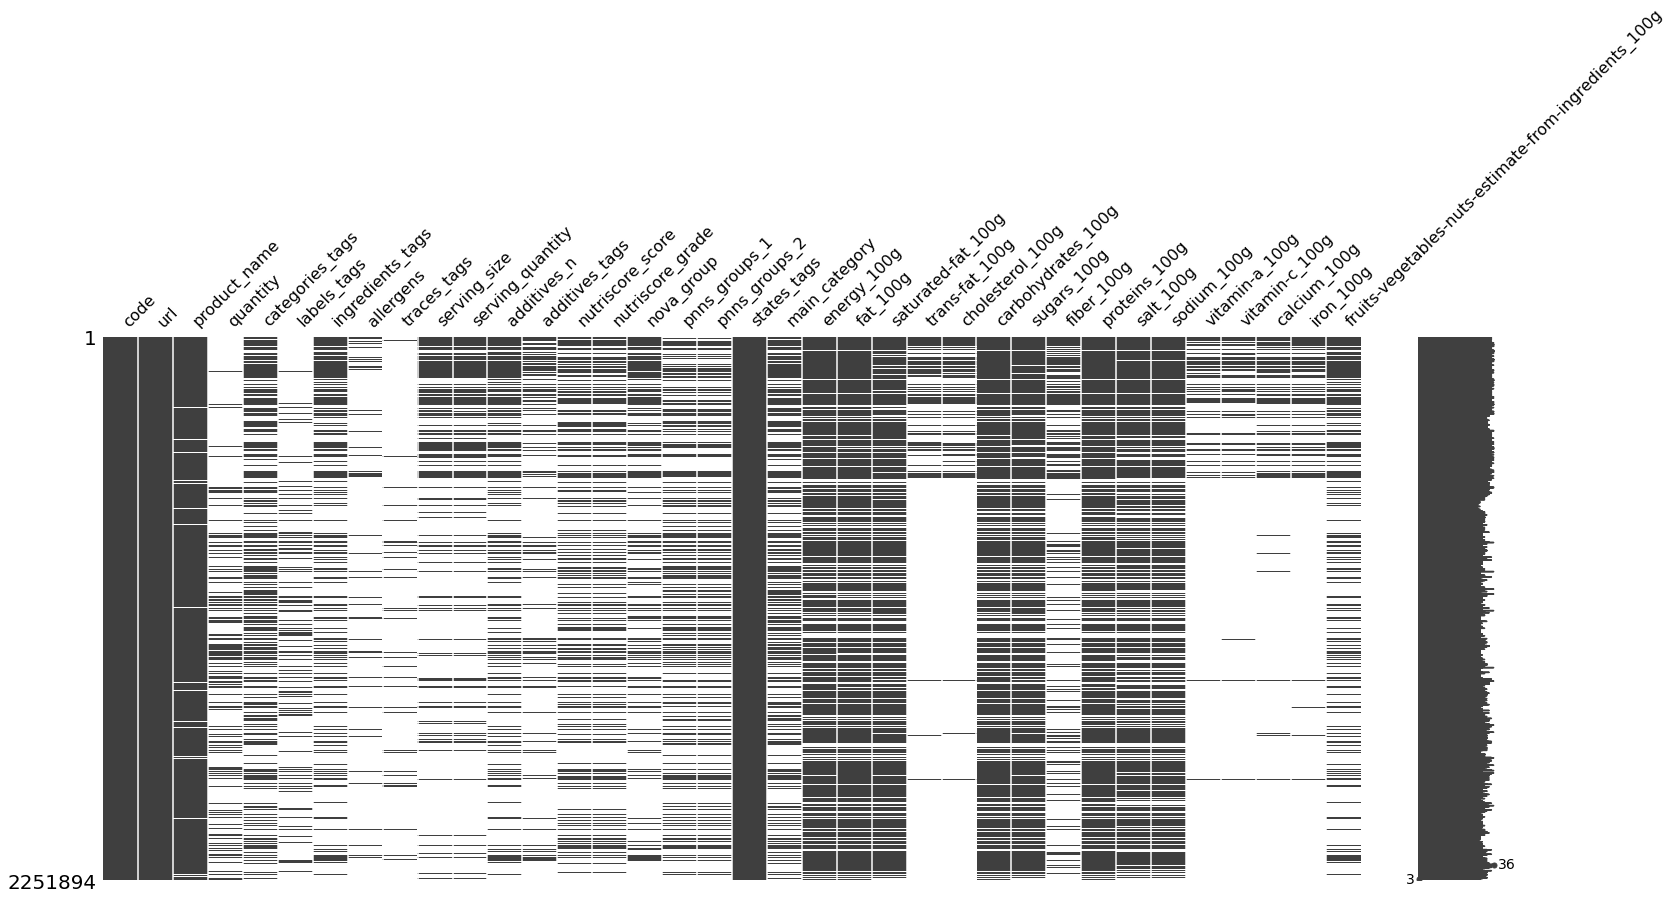

In [21]:
import missingno as msno
msno.matrix(data)

# 3. Identification des colonnes utiles <a class="anchor" id="P03"></a>

Malgré une première sélection, il reste encore beaucoup de colonnes dans ce jeu de données. Nous allons donc nous appuyer sur les les indications de la documentation du Nutri-grade pour essayer de trouver les colonnes les plus utiles ([Voir les infos dans l'objectif du projet](#P01))

Pour rappel, voici les éléments utilisés dans le calcule du Nutri-score et donc du Nutri-grade.

#### Éléments défavorables au score

- Apport calorique pour cent grammes.
- Teneur en sucre.
- Teneur en graisses saturées.
- Teneur en sel.

#### Éléments favorables au score

- Teneur en fruits, légumes, légumineuses (dont les légumes secs), oléagineux, huiles de colza, de noix et d'olive.
- Teneur en fibres.
- Teneur en protéines.

In [22]:
data.columns

Index(['code', 'url', 'product_name', 'quantity', 'categories_tags',
       'labels_tags', 'ingredients_tags', 'allergens', 'traces_tags',
       'serving_size', 'serving_quantity', 'additives_n', 'additives_tags',
       'nutriscore_score', 'nutriscore_grade', 'nova_group', 'pnns_groups_1',
       'pnns_groups_2', 'states_tags', 'main_category', 'energy_100g',
       'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g',
       'calcium_100g', 'iron_100g',
       'fruits-vegetables-nuts-estimate-from-ingredients_100g'],
      dtype='object')

In [23]:
var_selected = set()

### `Apport calorique pour cent grammes`

> Pour apporter cette information, nous pourrions utiliser `energy_100g`.
> 
> Son taux de replissage est de 79.34% et il ne semble pas y avoir d'alternative encore présente dans le dataset (certaines colonnes redondantes à celle-ci ont été préalablement supprimées, mais présentaient un taux de remplissage sensiblement équivalent).

In [24]:
var_selected.add('energy_100g')

### `Teneur en sucre`
> Pour apporter cette information, nous pourrions utiliser `sugars_100g`.
>
> Son taux de replissage est de 78.08%. La seule alternative visible est `carbohydrates_100g`, mais si les carbodydrates contiennent bien les sucres, l'inverse n'est pas vrai, donc il me semble moins adapté d'utiliser cette colonne.

In [25]:
data[['sugars_100g', 'carbohydrates_100g']]#['sugars_10c0g'].value_counts(dropna=False)

sugars_100g  carbohydrates_100g
0                NaN                 NaN
1              9.800               9.800
2             15.000              70.100
3                NaN                 NaN
4                NaN                 NaN
...              ...                 ...
2251889          NaN                 NaN
2251890          NaN                 NaN
2251891        0.600               2.400
2251892       49.000              70.000
2251893          NaN                 NaN

[2251894 rows x 2 columns]

In [26]:
var_selected.add('sugars_100g')

### `Teneur en graisses saturées`
> Pour apporter cette information, nous pourrions utiliser `saturated-fat_100g`.
>
> Son taux de replissage est de 76.89% et si `fat_100g` pourrait être une alternative intéressante, il ne semble pas nécessaire de remplacer l'une par l'autre (puisque le taux de remplissage est plus que correct), et que si les fat_100g contiennent bien les saturated-fat_100g, elles contiennent aussi d'autres types de graisses.

In [27]:
data[['saturated-fat_100g', 'fat_100g']].notnull().mean(axis=0)#['fat_100g'].value_counts(dropna=False)

saturated-fat_100g   0.769
fat_100g             0.789
dtype: float64

In [28]:
var_selected.add('saturated-fat_100g')

### `Teneur en sel`
> Pour apporter cette information, nous pourrions utiliser `salt_100g`.
>
> Son taux de replissage est de 72.84% et si `sodium_100g` aurait pu faire une alternative intéressante, il ne semble pas nécessaire de remplacer l'une par l'autre, puisque le taux de remplissage est identique et que l'une vaut l'autre avec un **ratio de 2.54**.

In [29]:
data[['salt_100g', 'sodium_100g']].notnull().mean(axis=0)#['fat_100g'].value_counts(dropna=False)

salt_100g     0.728
sodium_100g   0.728
dtype: float64

In [30]:
var_selected.add('salt_100g')

### `Teneur en fibres`
> Pour apporter cette information, nous pourrions utiliser `fiber_100g`.
>
> Son taux de replissage est seulement de 28.42%, mais je ne vois malheureusement aucune alternative pouvant prendre le relai.

In [31]:
var_selected.add('fiber_100g')

### `Teneur en protéines`
> Pour apporter cette information, nous pourrions utiliser `proteins_100g`.
>
> Son taux de replissage est de 78.98%, et il ne semble pas y avoir d'alternative présente dans le dataset.

In [32]:
var_selected.add('proteins_100g')

### `Teneur en fruits, légumes, légumineuses (dont les légumes secs), oléagineux, huiles de colza, de noix et d'olive.`
> Pour apporter cette information, nous pourrions utiliser `fruits-vegetables-nuts-estimate-from-ingredients_100g`.
>
> Son taux de replissage est de 33.47% et si `fruits-vegetables-nuts-dried_100g`, `fruits-vegetables-nuts-estimate_100g` ou `fruits-vegetables-nuts_100g` auraient pu faire une alternative intéressante, leur taux de remplissage est encore plus bas. Mais il pourrait être intéressant de voir si l'on peut se servir de celles-ci pour imputer `fruits-vegetables-nuts-estimate-from-ingredients_100g`.

> Cette colonne n'est pas suffisante seule, mais on retrouve en fait indirectement ces informations sur les légumes, légumineuses, oléagineux dans les colonnes déjà ajoutées (en particuliers proteins_100g et fiber_100g)

Profitons en pour renommer cette colonne au nom particulièrement long qui risque de rendre moins lisible les divers graphiques...

In [33]:
data.rename(columns={'fruits-vegetables-nuts-estimate-from-ingredients_100g':'FVN_estimate_100g'}, inplace=True)

In [34]:
var_selected.add('FVN_estimate_100g')

### `Informations de catégorisation du produit`

> Afin de pouvoir explorer la relation entre le type de produit et les variables que nous avons gardé précédemment, nous allons garder une colonne de ce type.

> Il y a trois variables qui pourraient servir à catégoriser les produits; `main_category`, `pnns_groups_1` et `pnns_groups_2`.

#### Explorons un peu les trois pour savoir laquelle ou lesquelles il faut garder.

In [35]:
from itertools import zip_longest

In [36]:
def eval_groups(maxiter=20):
    x = data.main_category.value_counts(dropna=False)
    y = data.pnns_groups_1.value_counts(dropna=False)
    z = data.pnns_groups_2.value_counts(dropna=False)

    size=25
    print(f"{'main_category'.upper().rjust(size+9)}\t{'pnns_groups_1'.upper().rjust(size+9)}\t{'pnns_groups_2'.upper().rjust(size+9)}")
    for i,(ai,a, bi,b, ci,c) in enumerate(zip_longest(x.index,x, y.index, y,z.index, z)):
        a = 0 if a == None else a
        b = 0 if b == None else b
        c = 0 if c == None else c
        print(f"{str(ai)[:size].rjust(size)} :{a:7}\t{str(bi)[:size].rjust(size)} :{b:7}\t{str(ci)[:size].rjust(size)} :{c:7}")
        if i > maxiter:
            break
            
eval_groups(15)

                     MAIN_CATEGORY	                     PNNS_GROUPS_1	                     PNNS_GROUPS_2
                     None :1240806	                     None :1435564	                     None :1435562
                en:snacks :  34348	            Sugary snacks : 169128	                   Sweets :  76620
                en:sauces :  17325	           Fish Meat Eggs : 115304	       Biscuits and cakes :  68817
              en:biscuits :  16543	  Milk and dairy products : 102191	     Dressings and sauces :  54952
       en:confectioneries :  16450	     Cereals and potatoes :  95113	                   Cheese :  50954
               en:cheeses :  16364	           Fat and sauces :  78861	           One-dish meals :  46234
             en:beverages :  12693	                Beverages :  74848	                  Cereals :  45444
                en:breads :  10484	    Fruits and vegetables :  62754	           Processed meat :  43028
       en:frozen-desserts :   9485	          Composite 

In [37]:
data[['main_category', 'pnns_groups_1', 'pnns_groups_2']].notnull().mean(0)#['pnns_groups_1'].value_counts(dropna=False)

main_category   0.449
pnns_groups_1   0.363
pnns_groups_2   0.363
dtype: float64

> Bien que `main_category` soit légèrement plus remplie que les deux autres (après le nettoyage des NaN fait plus haut...), le découpage qui apparait dans `pnns_groups_2` semble être le plus intéressant car moins granulaire; on va donc prendre cette colonne.

In [38]:
var_selected.add('pnns_groups_2')

### `Informations d'identification du produit`

> Pour aider à trouver les doublons, on va ajouter les variables `code` et `product_name`.

In [39]:
var_selected.add('code')
var_selected.add('product_name')

### `Scores de référence`
> Par ailleurs, comme le propos est de travailler sur le nutri-grade, il convient d'ajouter les colonnes concernées...

In [40]:
var_selected.add('nutriscore_score')
var_selected.add('nutriscore_grade')
var_selected.add('nova_group') # Pour comparaison

### Colonnes séléctionnées pour une application de prédiction du Nutri-grade

In [41]:
var_selected

{'FVN_estimate_100g',
 'code',
 'energy_100g',
 'fiber_100g',
 'nova_group',
 'nutriscore_grade',
 'nutriscore_score',
 'pnns_groups_2',
 'product_name',
 'proteins_100g',
 'salt_100g',
 'saturated-fat_100g',
 'sugars_100g'}

In [42]:
data_nutri = data[[*var_selected]]

### Explorons à nouveau ce jeu de données réduits pour les besoins de l'application

In [43]:
data_nutri.shape

(2251894, 13)

In [44]:
data_nutri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2251894 entries, 0 to 2251893
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   product_name        object 
 1   saturated-fat_100g  float64
 2   nutriscore_grade    object 
 3   salt_100g           float64
 4   fiber_100g          float64
 5   nova_group          object 
 6   proteins_100g       float64
 7   sugars_100g         float64
 8   FVN_estimate_100g   float64
 9   code                object 
 10  pnns_groups_2       object 
 11  energy_100g         float64
 12  nutriscore_score    float64
dtypes: float64(8), object(5)
memory usage: 223.3+ MB


In [45]:
data_nutri.describe().T

count                                           mean  \
saturated-fat_100g 1731439.000                                      57722.281   
salt_100g          1640254.000                                      60928.005   
fiber_100g          639994.000 153333860029341582185095018443795150667776.000   
proteins_100g      1778610.000                                      56198.842   
sugars_100g        1758313.000                                   56929545.382   
FVN_estimate_100g   753817.000                                          8.602   
energy_100g        1786722.000      3730607721228534090965745911682039808.000   
nutriscore_score    776383.000                                          9.091   

                                                                 std      min  \
saturated-fat_100g                                      75945867.241    0.000   
salt_100g                                               78028308.222    0.000   
fiber_100g         122666513020150478865288974968710559086673920.000   -6.700   
proteins_100g                                           74932009.551 -500.000   
sugars_100g                                          75414025717.789   -1.000   
FVN_estimate_100g                                             36.118    0.000   
energy_100g             4986640698625920150338062244302641168384.000    0.000   
nutriscore_score                                               8.849  -15.000   

                       25%      50%      75%  \
saturated-fat_100g   0.100    1.800    7.000   
salt_100g            0.083    0.590    1.400   
fiber_100g           0.000    1.600    3.700   
proteins_100g        1.300    6.000   12.500   
sugars_100g          0.600    3.570   17.100   
FVN_estimate_100g    0.000    0.000    0.500   
energy_100g        418.000 1079.000 1674.000   
nutriscore_score     1.000   10.000   16.000   

                                                                  max  
saturated-fat_100g                                    99932728111.000  
salt_100g                                             99932728111.000  
fiber_100g         98132750415618438665845168411918503733975056384...  
proteins_100g                                         99932728111.000  
sugars_100g                                       100000000376832.000  
FVN_estimate_100g                                           13461.000  
energy_100g           6665558888888888950360610417759390841962496.000  
nutriscore_score                                               40.000

> On remarque que beaucoup de colonnes numériques ont des valeurs `min`, `max` *(et donc `mean` et `std`)* clairement hors normes.
>
> Il va falloir s'occuper de toutes ces valeurs aberrantes.
---

In [46]:
data_nutri.describe(exclude="number").T

count   unique            top    freq
product_name      2166178  1387468           Miel    1449
nutriscore_grade   776383        5              d  240061
nova_group         679561        4              4  440248
code              2251894  2251873  3477610001135       2
pnns_groups_2      816332       41         Sweets   76620

> Sur la base des colonnes `code` *(sensées être uniques)*, on remarque qu'il y a au moins un doublon. Il faudra donc le(s) supprimer.
---

#### Affichons les taux de valeurs manquantes pour chaque colonne.

In [47]:
fill_ratio = print_fill_rate(data_nutri, data_nutri.columns)

      product_name |    85716 lignes vides | remplissage:  96.19%
saturated-fat_100g |   520455 lignes vides | remplissage:  76.89%
  nutriscore_grade |  1475511 lignes vides | remplissage:  34.48%
         salt_100g |   611640 lignes vides | remplissage:  72.84%
        fiber_100g |  1611900 lignes vides | remplissage:  28.42%
        nova_group |  1572333 lignes vides | remplissage:  30.18%
     proteins_100g |   473284 lignes vides | remplissage:  78.98%
       sugars_100g |   493581 lignes vides | remplissage:  78.08%
 FVN_estimate_100g |  1498077 lignes vides | remplissage:  33.47%
              code |        0 lignes vides | remplissage: 100.00%
     pnns_groups_2 |  1435562 lignes vides | remplissage:  36.25%
       energy_100g |   465172 lignes vides | remplissage:  79.34%
  nutriscore_score |  1475511 lignes vides | remplissage:  34.48%


> Visiblement, même allégé des colonnes les plus vides, ce jeu de données présente encore beaucoup de trous.

<AxesSubplot:>

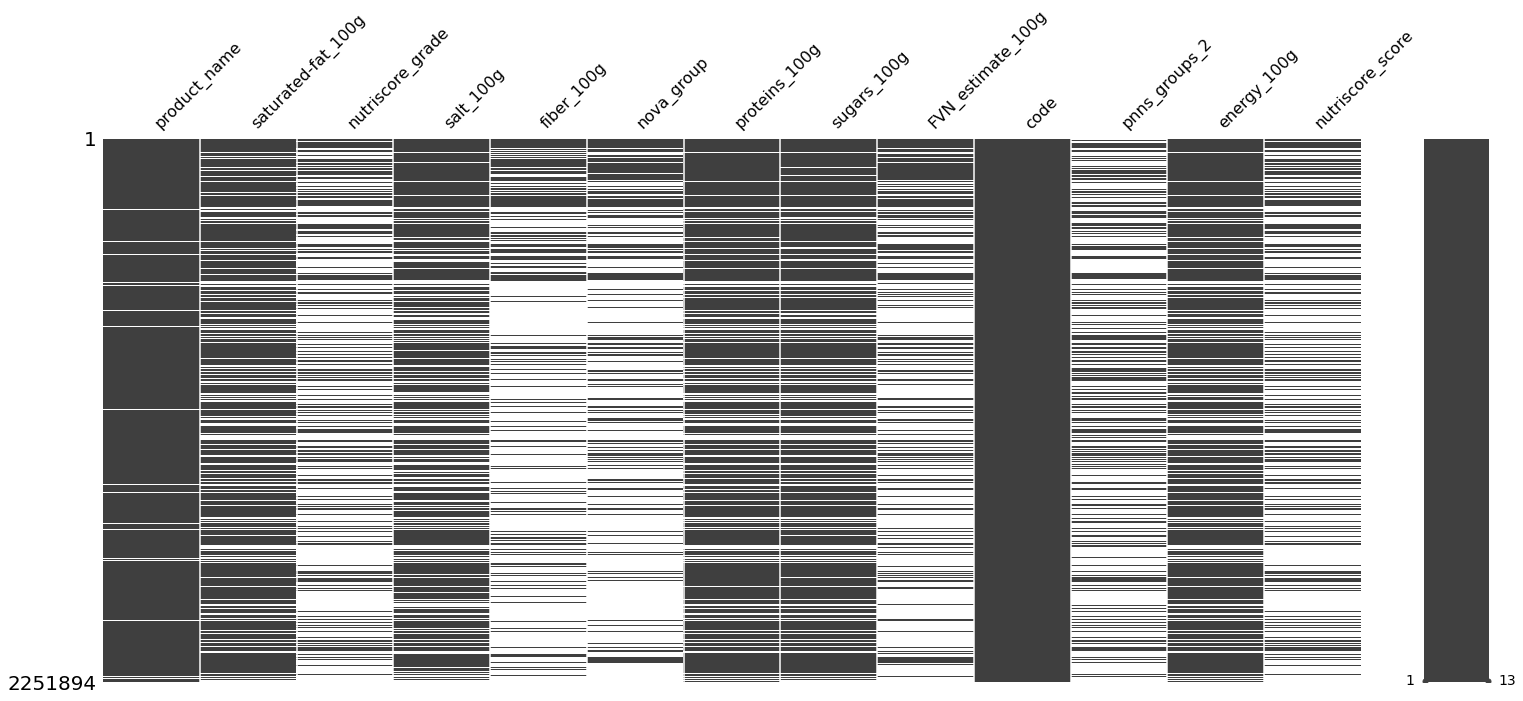

In [48]:
msno.matrix(data_nutri)

# 4. Démarche méthodologique d'analyse de données <a class="anchor" id="P04"></a>

## 4.1 Analyse univariée des variables <a class="anchor" id="P04_univariate"></a>

Le but d'une analyse univariée est de décrire les données pour en découvrir les caractéristiques et mieux les comprendre. Pour ce faire, on examine la moyenne, le mode, la médiane, l'écart type, la dispersion, etc. par le biais d'histogrammes, de tableaux de distribution de fréquence, de diagrammes à barres, ou autres.

In [49]:
vars_quantitatives = data_nutri.select_dtypes(include=np.number).columns
vars_qualitatives = data_nutri.select_dtypes(exclude=np.number).columns

#### Mettons en place quelques fonctions qui vont nous aider dans le travail d'exploration et de nettoyage

In [50]:
# Définissons une fonction permettant d'explorer les colonnes numériques

#import plotly.figure_factory as ff

def explore_quantitative(data, col_name):
    dt = data[col_name]
    print(dt.describe())
    
    #fig = px.box(dt, width=500, height=250)
    #fig.show()
    
    fig = plt.figure(figsize =(15, 3))
    
    
    ax = plt.subplot(1, 2, 1)
    sns.boxplot(x=dt[dt.notnull()])
    plt.title(f"Boxplot for '{col_name}'")
    
    ax = plt.subplot(1, 2, 2)
    sns.kdeplot(dt)
    plt.title(f"Density plot for '{col_name}'")
    
    #group_labels = ['distplot'] # name of the dataset
    #fig = ff.create_distplot([dt[dt.notnull()]], group_labels)
    #fig.show()

In [51]:
# Définissons une fonction permettant de calculer les valeurs min et max théoriques 
# sur la base des écarts inter-quantiles

def find_IQR_min_max(data, col_name):
    dt = data[col_name]
    Q1 = dt.quantile(0.25)
    Q3 = dt.quantile(0.75)
    EQ = Q3-Q1
    min_v = Q1 - 1.5* EQ
    max_v = Q3 + 1.5* EQ
    
    print(f"min:{min_v} max:{max_v}")
    
    return min_v, max_v

In [52]:
# Définissons une fonction permettant d'appliquer un filtre sur les valeurs hors bornes

def clip_column_values(data, col_name, min_v=None, max_v=None, min_new=None, max_new=None):
    dt = data.copy()
    count_start = dt[col_name].isin([max_new,min_new]).sum()
    
    if(min_v != None):
        dt[col_name].mask(dt[col_name] < min_v, min_new, inplace=True)
    if(max_v != None):
        dt[col_name].mask(dt[col_name] > max_v, max_new, inplace=True)
        
    count_end = dt[col_name].isin([max_new,min_new]).sum()
    
    print(f"On a modifié {count_end-count_start} lignes")
        
    return dt

In [53]:
# Définissons une fonction permettant d'afficher la répartition des données (sans pie-chart)

def display_fraction(data, col_name, title, ylabel="Remplissage (en %)", showscale=True, showtext=True):
    dt = data[col_name]

    fig = px.bar(dt, y=col_name, 
             #width=900,
             height=500,
             color=col_name, 
             title=title,
             labels={
                "fill_rate": ylabel,
                "index": "",
                },
             text_auto=showtext,
             template='ggplot2',
             #hover_data={'Fraction':':.2f'},
            )
    fig.update_coloraxes(showscale=showscale)
    fig.update_xaxes(tickangle = -45)
    fig.show()

In [54]:
def percent(value, total):
    return value/total*100.0

In [55]:
data_clean = data_nutri.copy()

---
### `nutriscore_score`

count   776383.000
mean         9.091
std          8.849
min        -15.000
25%          1.000
50%         10.000
75%         16.000
max         40.000
Name: nutriscore_score, dtype: float64


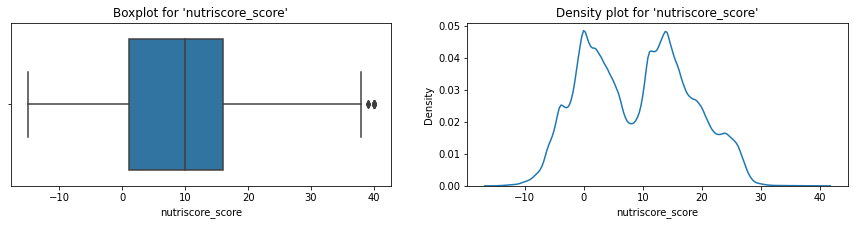

In [56]:
explore_quantitative(data_clean, 'nutriscore_score')

> Les valeurs s'étalent de -15 à 40 avec deux pics de densité autour de 0 et 15.
>
> D'après la documentation nutriscore, on doit avoir des scores allant de -15 à 40. Et c'est exactement ce que nous avons, donc il n'y a aucune raison de réduire les valeurs de cette colonne.
>
> Par ailleurs deux sommets sur le graphique de densité qui semblent correspondre aux nutrigrade B et D. *(voir [P34](https://www.santepubliquefrance.fr/content/download/150262/file/2021_07_21_QR_scientifique_et_technique_V42_VFR.pdf))*.<br> On peut donc supposer qu'il y a:
> - une quantité **moderée** de produits classés **A** [-15;-1]
> - une **petite** quantité de produits classés **B** [0;2] (car l'intervalle est très petit)
> - une quantité **moderée** de produits classés **C** [3;10]
> - une **grande** quantité de produits classés **D** [11;18]
> - une quantité **moderée** de produits classés **E** [18;40]

Vérifions ces suppositions en explorant la variable `nutriscore_grade`

---
### `nutriscore_grade`

In [57]:
data_clean['nutriscore_grade'].describe()

count     776383
unique         5
top            d
freq      240061
Name: nutriscore_grade, dtype: object

In [58]:
data_clean['nutriscore_grade'].value_counts(dropna=False).sort_index()

a        123964
b        102483
c        167000
d        240061
e        142875
None    1475511
Name: nutriscore_grade, dtype: int64

In [59]:
vcount = data_clean['nutriscore_grade'].value_counts(dropna=True).sort_index()
select_count = pd.DataFrame(vcount)

# On calcul le pourcentage
select_count = np.round(select_count / select_count.sum() * 100.0, 1)
select_count.rename(columns={'nutriscore_grade':'Pourcentage'}, inplace=True)

display_fraction(select_count, 'Pourcentage', 
                 "Repartition des Nutri-grades (sur les valeurs non-nulles)", 
                 showscale=True, showtext=True)

> On constate qu'il y a beaucoup de **D**, peu de **B** et modèrement du reste (**A**, **C**, **E**).
>
> Les suppositions faites lors de l'analyse univariée de `nutriscore_score` sont à peu près vérifiées, mais il conviendrait tout de même de regarder plus avant la relation entre ces deux variables.

> `Recommandation:` explorer la relation entre `nutriscore_score` et `nutriscore_grade` lors des analyses multivariées.

#### A présent regardons les variables nutritionnelles

---
### `saturated-fat_100g`

count       1731439.000
mean          57722.281
std        75945867.241
min               0.000
25%               0.100
50%               1.800
75%               7.000
max     99932728111.000
Name: saturated-fat_100g, dtype: float64


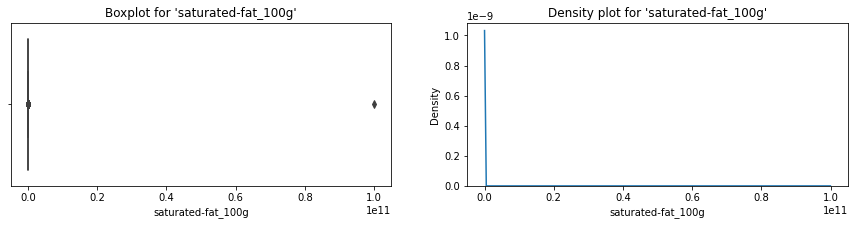

In [60]:
explore_quantitative(data_clean, 'saturated-fat_100g')

> On note que cette variable présente une grande dispersion des valeurs, et un maximum hors normes.
>
> On pourrait calculer l'IQR-max, mais la véritable valeurs max est trouvable, donc utilisons la:
>> Pour `saturated-fat_100g` le maximum semble être à **92.6** pour 100g /// **Pain de friture**
>
> Pour comparaison l'IQR-max trouve 17.35; ce qui est tout de même assez loin.

#### Appliquons une réduction des valeurs en utilisant le maximum réel connu

Remplaçons les valeurs supérieures à la valeur max connue, par des None

In [61]:
data_tmp = clip_column_values(data_clean, 'saturated-fat_100g', max_v=92.6, max_new=None)

On a modifié 817 lignes


#### Regardons à nouveau la variable une fois réduite

count   1730622.000
mean          5.013
std           7.597
min           0.000
25%           0.100
50%           1.800
75%           7.000
max          92.600
Name: saturated-fat_100g, dtype: float64


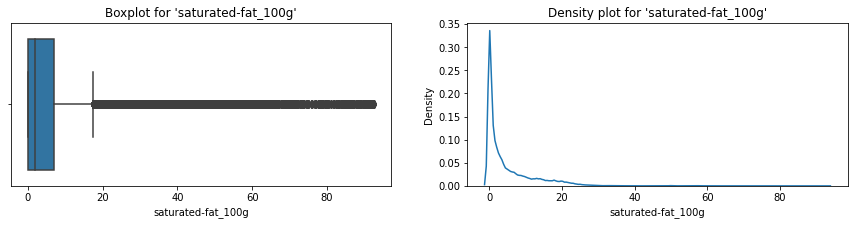

In [62]:
explore_quantitative(data_tmp, 'saturated-fat_100g')

> On note la présence de nombreuses valeurs atypiques, qui ne sont a-priori pas aberrantes.

#### Regardons de plus près ces valeurs hors-normes

In [63]:
count_atypical = data_tmp[ data_tmp['saturated-fat_100g'] > data_tmp['saturated-fat_100g'].quantile(0.75) ].shape[0]
count_normal = data_tmp[ data_tmp['saturated-fat_100g'] <= data_tmp['saturated-fat_100g'].quantile(0.75) ].shape[0]
total = data_tmp.shape[0]
print(f"Il y a {count_atypical} valeurs atypiques contre {count_normal} normales. Soit {count_atypical}/{total} ({percent(count_atypical, total):.2f}%)]")

Il y a 431466 valeurs atypiques contre 1299156 normales. Soit 431466/2251894 (19.16%)]


> C'est tout de même assez conséquant... explorons plus en détails les produits concernés.

In [64]:
data_tmp[ data_tmp['saturated-fat_100g'] > data_tmp['saturated-fat_100g'].quantile(0.75) ][['code','product_name','saturated-fat_100g']].head(13)

code                            product_name  saturated-fat_100g
23    000000000114                           Chocolate n 3              28.000
26   0000000001281                      Tarte noix de coco              15.500
29   0000000001328                        Chouquettes x 30              12.000
36    000000000188           Sablé aux pépites de chocolat              15.000
55   0000000004206  Saucisse au chou fumé BBC SV (Morteau)               9.700
61   0000000004530          Banana Chips Sweetened (Whole)              28.570
68   0000000005005                               Abondance              21.600
78   0000000007160                             CORNED BEEF               7.500
101   000000001231       Rillettes de sanglier au Chouchen              11.000
126  0000000016193            Organic Dark Chocolate Minis              22.500
127  0000000016513                   Organic Sunflower Oil               7.140
133  0000000017497                     Organic Spicy Punks               9.090
135   000000001757               Biscuits du Bourg de Batz               7.700

> En cherchant les valeurs de quelques produits de cette liste, on constate que ce sont pour l'essentiel des valeurs conformes à la réalité.

#### Appliquons donc la modification du dataset comme prévu.

In [65]:
data_clean = data_tmp.copy()

---
### `sugars_100g`

count           1758313.000
mean           56929545.382
std         75414025717.789
min                  -1.000
25%                   0.600
50%                   3.570
75%                  17.100
max     100000000376832.000
Name: sugars_100g, dtype: float64


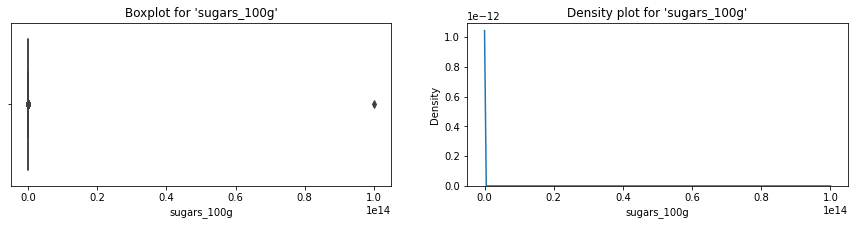

In [66]:
explore_quantitative(data_clean, 'sugars_100g')

> On note que cette variable présente une grande dispersion des valeurs, et un maximum hors normes.
>
> On pourrait calculer l'IQR-max, mais la véritable valeurs max est trouvable, donc utilisons la:
>> Pour `sugars_100g` le maximum semble être à **99.8g** pour 100g /// **Fructose**<br>
>> Et le minimum ne peux logiquement pas être sous **0**.
>
> Pour comparaison l'IQR-max trouve 41.85; ce qui est nettement au dessus du maximum réel.

#### Appliquons une réduction des valeurs en utilisant le maximum réel connu

Remplaçons les valeurs supérieures à la valeur max connue, par des None

In [67]:
data_tmp = clip_column_values(data_clean, 'sugars_100g', min_v=0, min_new=None, max_v=99.8, max_new=None)

On a modifié 3680 lignes


#### Regardons à nouveau la variable une fois réduite

count   1754633.000
mean         12.793
std          18.964
min           0.000
25%           0.600
50%           3.570
75%          17.000
max          99.800
Name: sugars_100g, dtype: float64


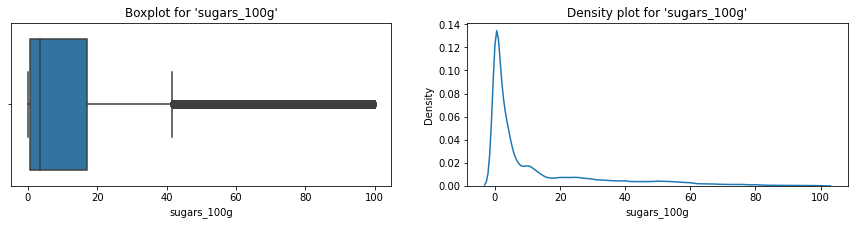

In [68]:
explore_quantitative(data_tmp, 'sugars_100g')

> On note un pic à 0, et bien que le reste des données soit bien réparti, il serait intéressant de regarder plus en détails.

In [69]:
count_zero = data_tmp[ data_tmp['sugars_100g'] == 0.0 ].shape[0]
total = data_tmp.shape[0]
print(f"Il y a {count_zero} valeurs à 0g de sucre. Soit {count_zero}/{total} ({percent(count_zero, total):.2f}%)")

Il y a 275357 valeurs à 0g de sucre. Soit 275357/2251894 (12.23%)


> Ca semble très conséquent, mais il apparait difficile de vérifier ces valeurs. Peut être qu'il y a une grosse proportion de produits type soda sans sucre etc.

> `Recommandation:` il conviendrait de regarder cette colonne sous le spectre de `pnns_groups_2`.

In [70]:
data_clean = data_tmp.copy()

---
### `fiber_100g`

count                                           639994.000
mean        153333860029341582185095018443795150667776.000
std      122666513020150478865288974968710559086673920.000
min                                                 -6.700
25%                                                  0.000
50%                                                  1.600
75%                                                  3.700
max     98132750415618438665845168411918503733975056384...
Name: fiber_100g, dtype: float64


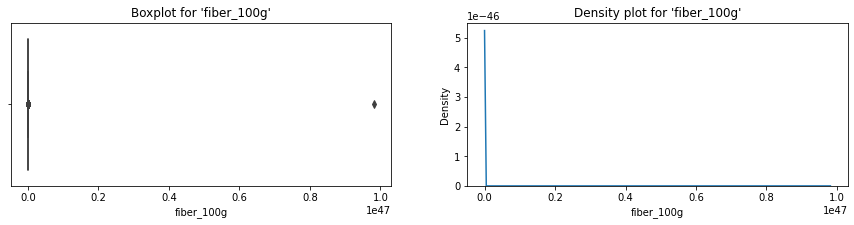

In [71]:
explore_quantitative(data_clean, 'fiber_100g')

> On note que cette variable présente une grande dispersion des valeurs, un minimum négatif et un maximum hors normes.
>
> On pourrait calculer les IQR min et max, mais les véritables valeurs min et max sont trouvable, donc utilisons les:
>> Pour `fiber_100g` le maximum semble être à **43.5g** pour 100g /// **Cannelle**<br>
>> Et le minimum ne peux logiquement pas être sous **0**.
>
> Pour comparaison l'IQR-max trouve 9.25; ce qui est nettement au dessus du maximum réel.

#### Appliquons une réduction des valeurs en utilisant le maximum réel connu

Remplaçons les valeurs supérieures à la valeur max connue, par des None

In [72]:
data_tmp = clip_column_values(data_clean, 'fiber_100g', min_v=0, min_new=None, max_v=43.5, max_new=None)

On a modifié 2074 lignes


#### Regardons à nouveau la variable une fois réduite

count   637920.000
mean         3.013
std          4.517
min          0.000
25%          0.000
50%          1.600
75%          3.600
max         43.500
Name: fiber_100g, dtype: float64


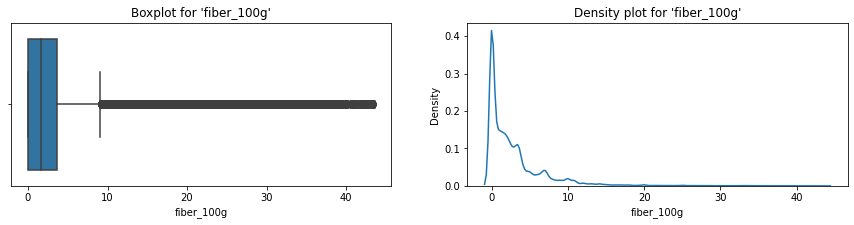

In [73]:
explore_quantitative(data_tmp, 'fiber_100g')

> On note là encore un pic à 0, mais le reste des données est bien réparti et on devrait donc pouvoir en tirer quelque chose.

In [74]:
count_zero = data_tmp[ data_tmp['fiber_100g'] == 0.0 ].shape[0]
total = data_tmp.shape[0]
print(f"Il y a {count_zero} valeurs à 0g de fibres. Soit {count_zero}/{total} ({percent(count_zero, total):.2f}%)")

Il y a 190161 valeurs à 0g de fibres. Soit 190161/2251894 (8.44%)


> Ca semble très conséquent, mais ça ne semble pas incohérant; il y a sans doute beaucoup de boissons, produits laitiers et autres produits sans fibres...

> `Recommandation:` il conviendrait de regarder cette colonne sous le spectre de `pnns_groups_2`.

In [75]:
data_clean = data_tmp.copy()

---
### `proteins_100g`

count       1778610.000
mean          56198.842
std        74932009.551
min            -500.000
25%               1.300
50%               6.000
75%              12.500
max     99932728111.000
Name: proteins_100g, dtype: float64


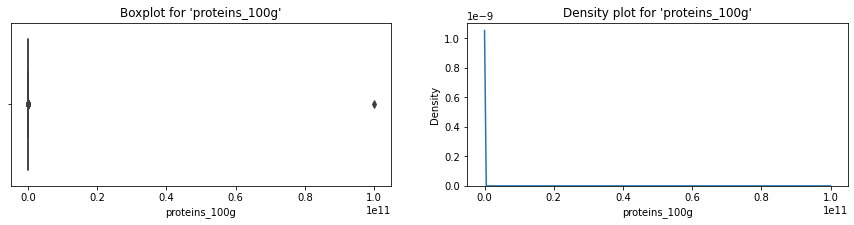

In [76]:
explore_quantitative(data_clean, 'proteins_100g')

> On note que cette variable présente une grande dispersion des valeurs, un minimum négatif et un maximum hors normes.
>
> On pourrait calculer les IQR min et max, mais les véritables valeurs min et max sont trouvable, donc utilisons les:
>> Pour `proteins_100g` le maximum semble être à **87.6g** pour 100g /// **Gélatine alimentaire**<br>
>> Et le minimum ne peux logiquement pas être sous **0**.
>
> Pour comparaison l'IQR-min trouve -15.5 et l'IQR-max trouve 29.29. Ce qui ne semble pas très adapté.

#### Appliquons une réduction des valeurs en utilisant le maximum réel connu

Remplaçons les valeurs supérieures à la valeur max connue, par des None

In [77]:
data_tmp = clip_column_values(data_clean, 'proteins_100g', min_v=0, min_new=None, max_v=87.6, max_new=None)

On a modifié 1381 lignes


#### Regardons à nouveau la variable une fois réduite

count   1777229.000
mean          8.681
std           9.859
min           0.000
25%           1.300
50%           6.000
75%          12.500
max          87.600
Name: proteins_100g, dtype: float64


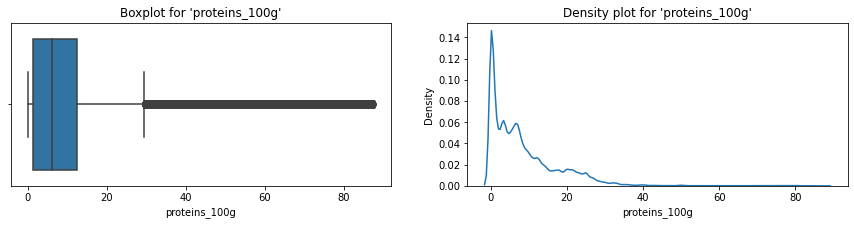

In [78]:
explore_quantitative(data_tmp, 'proteins_100g')

> Ca semble bien, donc on l'applique sur data_clean

In [79]:
count_zero = data_tmp[ data_tmp['proteins_100g'] == 0.0 ].shape[0]
total = data_tmp.shape[0]
print(f"Il y a {count_zero} valeurs à 0g de protéines. Soit {count_zero}/{total} ({percent(count_zero, total):.2f}%)")

Il y a 222650 valeurs à 0g de protéines. Soit 222650/2251894 (9.89%)


> Ca semble conséquent, mais ça ne semble pas incohérant; il y a sans doute beaucoup de produits sans protéines (à commencer par les boissons)...

> `Recommandation:` il conviendrait de regarder cette colonne sous le spectre de `pnns_groups_2`.

In [80]:
data_clean = data_tmp.copy()

---
### `salt_100g`

count       1640254.000
mean          60928.005
std        78028308.222
min               0.000
25%               0.083
50%               0.590
75%               1.400
max     99932728111.000
Name: salt_100g, dtype: float64


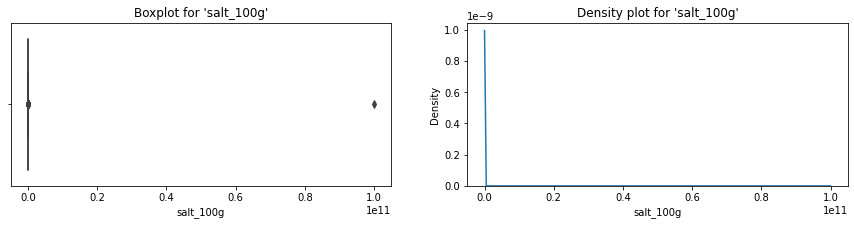

In [81]:
explore_quantitative(data_clean, 'salt_100g')

> On note que cette variable présente une grande dispersion des valeurs, et un maximum hors normes.
>
> On pourrait calculer les IQR min et max, mais les véritables valeurs min et max sont trouvable, donc utilisons les:
>> Pour `salt_100g` le maximum semble être à **39.1g** (39100 mg) pour 100g /// **sel blanc non iodé non fluoré**
>
> Pour comparaison l'IQR-max trouve 3.37. Ce qui est près de 10 fois moindre.

#### Appliquons une réduction des valeurs en utilisant le maximum réel connu

Remplaçons les valeurs supérieures à la valeur max connue, par des None

In [82]:
data_tmp = clip_column_values(data_clean, 'salt_100g', max_v=39.1, max_new=None)

On a modifié 6457 lignes


#### Regardons à nouveau la variable une fois réduite

count   1633797.000
mean          1.149
std           2.342
min           0.000
25%           0.080
50%           0.580
75%           1.400
max          39.062
Name: salt_100g, dtype: float64


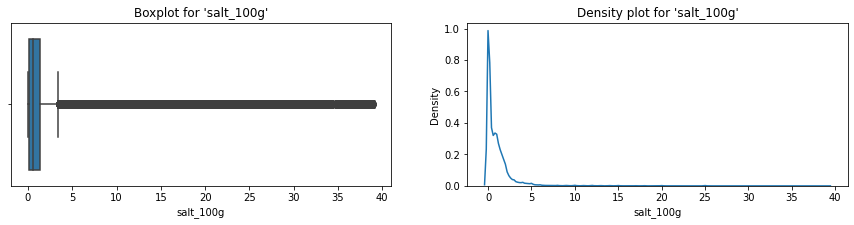

In [83]:
explore_quantitative(data_tmp, 'salt_100g')

> On constate qu'il y a beaucoup de valeur atypiques... Regardons plus en détails.

In [84]:
count_atypical = data_tmp[ data_tmp.salt_100g > data_tmp.salt_100g.quantile(0.75) ].shape[0]
count_normal = data_tmp[ data_tmp.salt_100g <= data_tmp.salt_100g.quantile(0.75) ].shape[0]
total = data_tmp.shape[0]
print(f"Il y a {count_atypical} valeurs atypiques contre {count_normal} normales. Soit {count_atypical}/{total} ({percent(count_atypical, total):.2f}%)]")

Il y a 395554 valeurs atypiques contre 1238243 normales. Soit 395554/2251894 (17.57%)]


> C'est tout de même assez conséquant... explorons les produits concernés.

In [85]:
data_tmp[ data_tmp.salt_100g > data_tmp.salt_100g.quantile(0.75) ][['code','product_name','salt_100g']].head(13)

code                            product_name  salt_100g
5   000000000004622327            Hamburguesas de ternera 100%      2.100
7        0000000000100             moutarde au moût de raisin       4.600
8        0000000000123                   Sauce Sweety chili 0%      2.040
28       0000000001311              Salade de fruits exotiques      3.200
29       0000000001328                        Chouquettes x 30      1.500
38       0000000002042                        Paëlla de poulet      2.800
45       0000000002417                           Ciabatta Roma      4.510
47       0000000003018                           Salade tomate      5.000
52       0000000003780                       Coca des flandres      9.000
54       0000000003827                          Suedois saumon      3.580
55       0000000004206  Saucisse au chou fumé BBC SV (Morteau)      2.600
64       0000000004572                           Pain epeautre      1.800
69       0000000005081                            Salade verte     18.300

> Si l'on regarde par exemple la dernière entrée `Salade verte`, on constate un taux de sel très élévé de 18.3g / 100g.
>
> Mais si je compare avec une [autre source](https://ciqual.anses.fr/#/aliments/25604/salade-verte-crue-sans-assaisonnement), on constate que le taux est en fait de 18.3**mg** / 100g ... Donc le taux saisi est 1000 fois superieur à la réalité.
>
> C'est certainement un problème récurrent car la valeur de sel affichée sur les emballages est parfois en **grammes** (commen attendu) et parfois en **milli-grammes** (1000 fois mois que l'unitée attendue). Les volontaires ont donc possiblement oublié de convertir en **grammes**.

#### Utilisons donc tout de même l'IQR-max à la place de la valeur max connue, pour retirer les outliers 
Notons que la distribution n'étant pas `normale` cette approche n'est pas idéale.

In [86]:
min_v, max_v = find_IQR_min_max(data_clean, 'salt_100g')

min:-1.8937499999999998 max:3.3762499999999998


Remplaçons les valeurs supérieures à la valeur max connue, par des None

In [87]:
data_tmp = clip_column_values(data_clean, 'salt_100g', max_v=max_v, max_new=None)

On a modifié 105913 lignes


#### Regardons à nouveau la variable une fois réduite

count   1534341.000
mean          0.727
std           0.775
min           0.000
25%           0.059
50%           0.490
75%           1.200
max           3.376
Name: salt_100g, dtype: float64


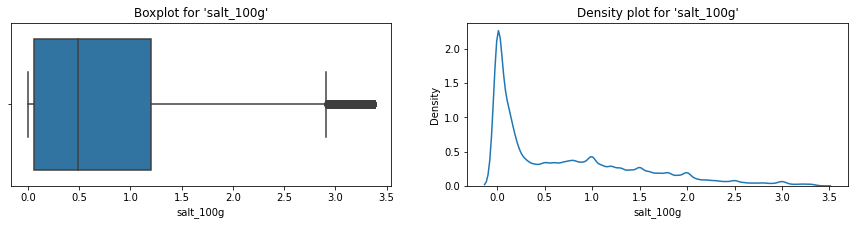

In [88]:
explore_quantitative(data_tmp, 'salt_100g')

> Ça semble plus raisonnable, mais vérifions le pic de densité à 0 avant d'appliquer les modifications sur data_clean.

In [89]:
count_zero = data_tmp[ data_tmp['salt_100g'] == 0.0 ].shape[0]
total = data_tmp.shape[0]
print(f"Il y a {count_zero} valeurs à 0g de sel. Soit {count_zero}/{total} ({percent(count_zero, total):.2f}%)")

Il y a 250593 valeurs à 0g de sel. Soit 250593/2251894 (11.13%)


> Ca semble conséquent, mais ça ne semble pas incohérant; les boissons, yogourts etc n'ont souvent pas de sel.

> `Recommandation:` il conviendrait de regarder cette colonne sous le spectre de `pnns_groups_2`.

In [90]:
data_clean = data_tmp.copy()

---
### `FVN_estimate_100g` (anciennement `fruits-vegetables-nuts-estimate-from-ingredients_100g`)

In [91]:
pd.set_option('display.float_format', lambda x: '%.10f' % x)

count   753817.0000000000
mean         8.6021028285
std         36.1179001768
min          0.0000000000
25%          0.0000000000
50%          0.0000000000
75%          0.5000000000
max      13461.0000000000
Name: FVN_estimate_100g, dtype: float64


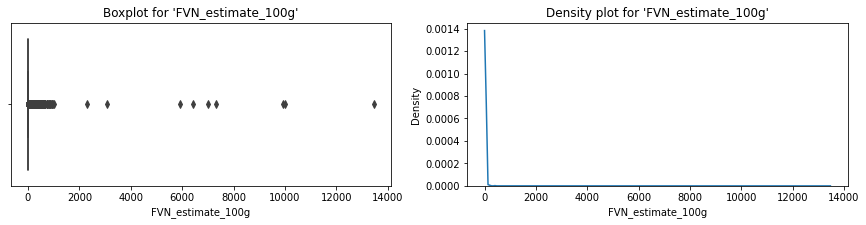

In [92]:
explore_quantitative(data_clean, 'FVN_estimate_100g')

> On note que la majorité des valeurs semblent être très très proches de 0 ou même égales à 0. <br>Par ailleurs on note un maximum hors-normes.

> La distribution n'étant pas `normale`, il apparait difficile d'utiliser l'écart inter-quartile pour déterminer les valeurs min et max...<br>donc on va simplement restraindre à un intervalle de **0 à 100**.

#### Appliquons une réduction

In [93]:
data_tmp = clip_column_values(data_clean, 'FVN_estimate_100g', max_v=100.0, max_new=None)

On a modifié 1083 lignes


#### Regardons à nouveau la variable une fois réduite

count   752734.0000000000
mean         8.2445773061
std         21.6847844593
min          0.0000000000
25%          0.0000000000
50%          0.0000000000
75%          0.4000000000
max        100.0000000000
Name: FVN_estimate_100g, dtype: float64


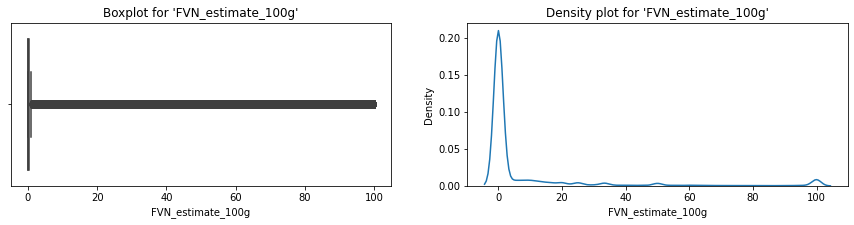

In [94]:
explore_quantitative(data_tmp, 'FVN_estimate_100g')

> On constate qu'il y a beaucoup de valeurs atypiques... Explorons plus en détails.

In [95]:
count_atypical = data_tmp[ data_tmp.salt_100g > data_tmp.salt_100g.quantile(0.75) ].shape[0]
count_normal = data_tmp[ data_tmp.salt_100g <= data_tmp.salt_100g.quantile(0.75) ].shape[0]
total = data_tmp.shape[0]
print(f"Il y a {count_atypical} valeurs atypiques contre {count_normal} normales. Soit {count_atypical}/{total} ({percent(count_atypical, total):.2f}%)]")

Il y a 372636 valeurs atypiques contre 1161705 normales. Soit 372636/2251894 (16.55%)]


> C'est tout de même assez conséquant... explorons les produits concernés.

In [96]:
data_tmp[ data_tmp['FVN_estimate_100g'] > data_tmp['FVN_estimate_100g'].quantile(0.75) ][['code','product_name','FVN_estimate_100g']].head(13)

code                            product_name  FVN_estimate_100g
54   0000000003827                          Suedois saumon      29.6000000000
60   0000000004510                   Salade shaker taboulé      13.6857142857
61   0000000004530          Banana Chips Sweetened (Whole)      25.0000000000
62   0000000004559                                 Peanuts      11.1111111111
72   0000000005272       Sandwich solene céréales sicilien      60.4000000000
121  0000000016087                  Organic Salted Nut Mix      20.0000000000
131  0000000016872                           Zen Party Mix      20.0000000000
133  0000000017497                     Organic Spicy Punks      25.0000000000
138  0000000018050                       Organic Hazelnuts     100.0000000000
139  0000000018173          Organic Sweetened Banana Chips      33.3333333333
145  0000000018340  Fire Roasted Hatch Green Chile Almonds      33.3333333333
146  0000000018357               Peanut Butter Power Chews      12.5000000000
150  0000000018395     Roasted Salted Black Pepper Cashews      25.0000000000

In [97]:
count_zero = data_tmp[ data_tmp['FVN_estimate_100g'] == 0.0 ].shape[0]
total = data_tmp.shape[0]
print(f"Il y a {count_zero} valeurs à 0g. Soit {count_zero}/{total} ({percent(count_zero, total):.2f}%)")

Il y a 561564 valeurs à 0g. Soit 561564/2251894 (24.94%)


> Ça semble très conséquent, mais plusieurs produits apparaissant dans la liste semblent correspondre aux valeurs données (par exemple `Organic Hazelnuts` avec 100g détient effectivement 100g de fruits secs puisque ce sont des noisettes).

> `Recommandation:` il conviendrait de regarder cette colonne sous le spectre de `pnns_groups_2`.

In [98]:
data_clean = data_tmp.copy()

---
### `energy_100g`

count                                   1786722.0000000000
mean      3730607721228534090965745911682039808.0000000000
std     4986640698625920150338062244302641168384.000000...
min                                           0.0000000000
25%                                         418.0000000000
50%                                        1079.0000000000
75%                                        1674.0000000000
max     6665558888888888950360610417759390841962496.000...
Name: energy_100g, dtype: float64


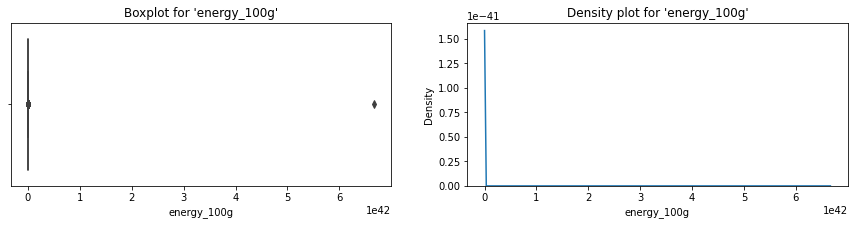

In [99]:
explore_quantitative(data_clean, 'energy_100g')

> On note que cette variable présente une grande dispersion des valeurs, et un maximum hors normes.
>
> On pourrait calculer l'IQR-max, mais la véritable valeurs max est trouvable, donc utilisons la:
>> Pour `energy_100g` le maximum semble être à **3765.6 kcal** pour 100g /// **Huile d'avocat**
>
> Pour comparaison l'IQR-max trouve 3558, ce qui n'est pas si loin, mais un peu en dessous quand même.

#### Appliquons une réduction des valeurs en utilisant le maximum réel connu

Remplaçons les valeurs supérieures à la valeur max connue, par des None

In [100]:
data_tmp = clip_column_values(data_clean, 'energy_100g', max_v=3765.6, max_new=None)

On a modifié 13236 lignes


#### Regardons à nouveau la variable une fois réduite

count   1773486.0000000000
mean       1116.8129951546
std         783.9668741853
min           0.0000000000
25%         418.0000000000
50%        1067.0000000000
75%        1665.0000000000
max        3765.0000000000
Name: energy_100g, dtype: float64


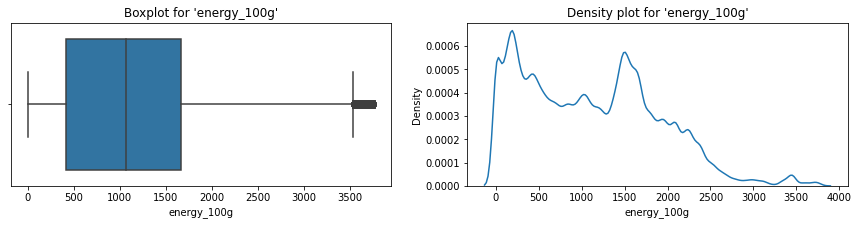

In [101]:
explore_quantitative(data_tmp, 'energy_100g')

> On note deux piques de densité autour de 250 et 1750; il faudra regarder si ça correspond a des catégories de produits, nutrigrade ou nova-group sur-représenté ou non.

> `Recommandation:` il conviendrait de regarder cette colonne sous le spectre de `pnns_groups_2`.

In [102]:
data_clean = data_tmp.copy()

#### Analysons à présent les variables nominales restantes

---
### `code`

In [103]:
data_clean['code'].describe()

count           2251894
unique          2251873
top       3477610001135
freq                  2
Name: code, dtype: object

In [104]:
data_clean['code'].unique()[:20]

array(['00000000000000225', '00000000000003429145', '0000000000017',
       '0000000000031', '000000000003327986', '000000000004622327',
       '00000000001', '0000000000100', '0000000000123', '0000000000178',
       '0000000000208', '0000000000284', '0000000000291', '000000000054',
       '000000000075', '000000000080', '000000000088', '0000000000949',
       '0000000000970', '0000000001001'], dtype=object)

In [105]:
data_clean.shape[0] - len(data_clean['code'].unique())

21

In [106]:
data_clean['code'].isnull().sum()

0

> On note la présence de 21 un doublon sur la base du code barre. Il faudra les supprimer.<br>
> Mais aucune des lignes n'est vide.

> Par ailleurs, le format saisi semble varié. Il se pourrait qu'il y ait différent types de code-barres stockés dans cette colonne...

> `Recommandations:` garder la colonne pour faciliter la recherche d'un produit par code-barre. **Supprimer les doublons**.

---
### `product_name`

In [107]:
data_clean['product_name'].describe()

count     2166178
unique    1387468
top          Miel
freq         1449
Name: product_name, dtype: object

#### Regardons également la répartition de ces valeurs

In [108]:
data_clean['product_name'].value_counts(dropna=False)

None                            85716
Miel                             1449
Aceite de oliva virgen extra     1434
Filet de poulet                  1159
Comté                             998
                                ...  
Kiri Dip&Crunch                     1
Trio de noix                        1
Boursin trio de noix                1
Mini light                          1
Signal Toothpaste                   1
Name: product_name, Length: 1387469, dtype: int64

In [109]:
vcount = data_clean['product_name'].value_counts(dropna=True)
select_count = pd.DataFrame(vcount)

# On calcul le pourcentage
#select_count = np.round(select_count / select_count.sum() * 100.0, 1)
select_count.rename(columns={'product_name':'Quantité'}, inplace=True)

# On selectionne les 25 premiers
select_count = select_count[:25]

display_fraction(select_count, 'Quantité', 
                 "Top 25 des noms de produits les plus communs", 
                 showscale=True, showtext=True)

#### Combien de produits ont un nom unique ?

In [110]:
data_clean['product_name'].isin(vcount.index[vcount<=1.0]).sum()

1212072

#### Et combien en manque-t-il ?

In [111]:
data_clean['product_name'].isnull().sum()

85716

> Si la grande majorité sont des produits uniques (1.212.072), on a visiblement de nombreux produits portant le même nom. Mais ce n'est pas vraiment étonnant, car on peut avoir des noms très générique *(par exemple le mode est ici "Miel" avec 1449 instances)* avec des valeurs nutritionnelles différentes. Il n'y a donc pas de raison de supprimer les doublons.
>
> On note d'ailleurs que plus de 85k produits n'ont pas de nom... C'est donc une colonne pratique pour savoir de quoi il retourne ou rechercher un produit dans le jeu de données, mais certainement pas une colonne critique pour calculer un score.

> `Recommandation:` garder la colonne pour faciliter la recherche d'un produit selon le nom.

---
### `pnns_groups_2`

In [112]:
data_clean['pnns_groups_2'].describe()

count     816332
unique        41
top       Sweets
freq       76620
Name: pnns_groups_2, dtype: object

In [113]:
data_clean['pnns_groups_2'].value_counts(dropna=False)

None                                1435562
Sweets                                76620
Biscuits and cakes                    68817
Dressings and sauces                  54952
Cheese                                50954
One-dish meals                        46234
Cereals                               45444
Processed meat                        43028
Meat                                  35738
Milk and yogurt                       35617
Vegetables                            33982
Fish and seafood                      30938
Bread                                 24984
Sweetened beverages                   24564
Fats                                  23909
Alcoholic beverages                   20103
Fruits                                18935
Chocolate products                    16382
Salty and fatty products              15594
Appetizers                            13240
Unsweetened beverages                 12316
Breakfast cereals                     10943
Fruit juices                    

> On constate qu'il y a 41 super-catégories, qui ont chacune de 1 à 75620 produits.

#### Affichons la répartition des catégories les plus fréquentes
(top 25, sur la base du nombre de produits par catégories)

In [114]:
select_count = pd.DataFrame(data_clean['pnns_groups_2'].value_counts(dropna=True))

# On calcul le pourcentage
select_count = np.round(select_count / select_count.sum() * 100.0, 1)
select_count.rename(columns={'pnns_groups_2':'Pourcentage'}, inplace=True)

# On selectionne les 25 premiers
select_count = select_count[:25]

display_fraction(select_count, 'Pourcentage', "Repartition (en % des non-nulls) de produits par catégories principales (Top 25 uniquement & hors None)", showscale=True, showtext=True)

> On constate que la catégorie "others" prend la seconde place derrière "snacks" avec environ 2.2% des lignes catégorisées (hors NaN donc).

#### Enfin, vérifions combien de produits n'ont pas de valeur `main_category`

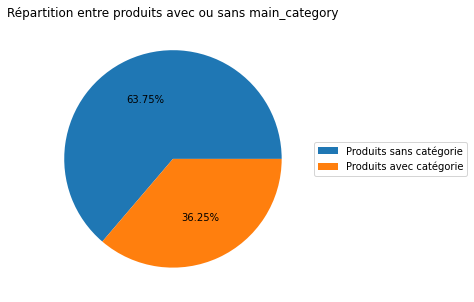

Il y a 1435562 produits non catégorisés (soit 63.75% des catégories)


In [115]:
total_size = data_clean.shape[0]
total_size_nonull = data_clean['pnns_groups_2'].count()
total_size_null = data_clean['pnns_groups_2'].isnull().sum()

fig = plt.figure(figsize=[15,5])

plt.pie(list([total_size_null,total_size_nonull]), 
        labels=["", ""],
        autopct=lambda x: f"{x:.2f}%", shadow=False)
plt.title("Répartition entre produits avec ou sans main_category")
plt.legend(["Produits sans catégorie", "Produits avec catégorie"], loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

print(f"Il y a {total_size_null} produits non catégorisés (soit {percent(total_size_null,total_size):.2f}% des catégories)")

> `Recommandation:` on peut essayer d'imputer cette colonne avec un KNN.

## 4.2 Analyse multivariée <a class="anchor" id="P04_multivariate"></a>

Les analyses multivariées ont pour vocation de mettre en évidence des informations sur les relations entre variables. Mais sans objectif on peut croiser beaucoup de données sans vraiment savoir ce que l'on cherche...

Voici donc les objectifs pour lesquels il serait utile d'avoir des informations:
1. Vérifier la relation entre `nutriscore_score` et les divers indicateurs des nutriments.
2. Vérifier la relation entre `nutriscore_grade` et les divers indicateurs des nutriments.
3. Vérifier la relation entre `nutriscore_score` et `nutriscore_grade`
4. Vérifier la relation entre `nutriscore_grade` et `pnns_groups_2`

---

### Commençons par vérifier les indices de corrélation entre les variables numériques. <a class="anchor" id="P03_correlation_num"></a>

Il existe plusieurs types de relations entre des variables numériques. Par exemple les rélations linéaires ou encore les relations monotones.
- Dans une relation linéaire, les variables se déplacent dans la même direction à un rythme constant.
- Dans une relation monotone, les variables ont tendance à se déplacer dans la même direction relative, mais pas nécessairement à un rythme constant.


Pour ces deux mesures les valeurs peuvent aller de -1 à 1 (inclus):
- -1 indique une relation forte dans le sens inverse (corrélation négative)
- +1 indique une relation forte dans le même sens (corrélation positive)
- 0  indique qu'il n'y a pas de relation.

Calculons donc les deux pour voir si quelque chose s'en dégage.

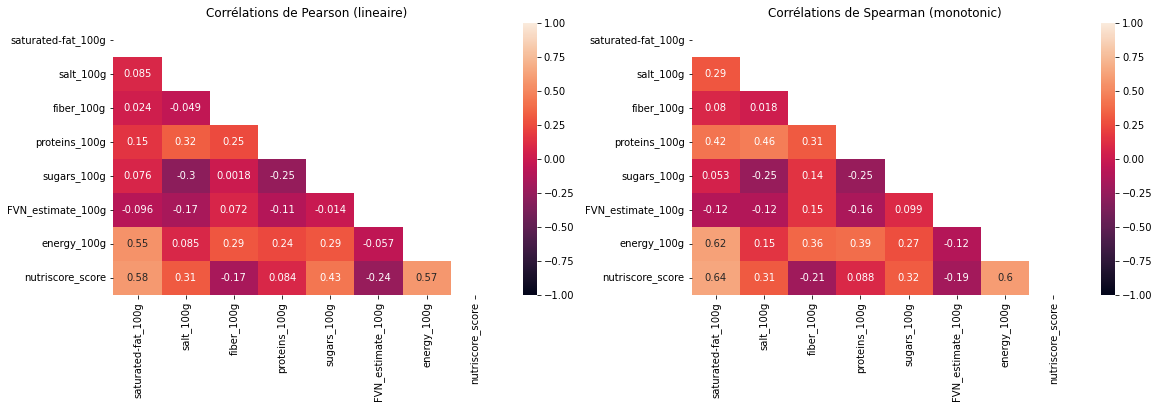

In [116]:
fig = plt.figure(figsize=(19,5))

plt.subplot(1,2,1)
corr= data_clean.corr(method="pearson")
matrix = np.triu(corr)
ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=matrix)
ax.set_title('Corrélations de Pearson (lineaire)')
ax.legend

plt.subplot(1,2,2)
corr= data_clean.corr(method="spearman")
matrix = np.triu(corr)
ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=matrix)
ax.set_title('Corrélations de Spearman (monotonic)')

plt.show()

> Si l'on s'intéresse à la colonne **`nutriscore_score`**, on remarque qu'elle est **corrélée à divers degrès avec toutes les colonnes** sauf `proteins_100g`. C'est plutôt une bonne nouvelle, car hormis `proteins_100g`, on devrait pouvoir s'appuyer sur ces colonnes pour essayer de prédire le score et donc le grade.
> 
> Le sens des corrélations constatées est d'ailleurs raccord avec ce que l'on était en droit d'espèrer d'après la documentation du Nutriscore; une corrélation positive pour `saturated-fat_100g`, `sugars_100g`, `salt_100g`, `energy_100g` et une corrélation négative pour `fiber_100g`, `FNV_estimate_100g`, `proteins_100g` *(puisque plus le `nutriscore_score` est grand moins c'est favorable et inversement plus il est bas et plus c'est favorable)*.

> On note que globalement, la plupart des éléments nutritifs présents dans ce tableau sont corrélés à divers degrés avec les autres éléments. Il y a finalement assez peu de relation neutres (`nutriscore_score` avec `proteins_100g`, `fiber_100g` avec `salt_100g`, `sugars_100g` avec `FVN_estimate_100g` ou `saturated-fat_100g`)...

---

#### Vérifions les relations entre `nutriscore_score` et les autres variables numériques
avec des `régressions linéaires` et le `coéfficient de détermination R²`

Pour le coéfficient de détermination R², les valeurs peuvent aller de 0 à 1 (inclus):
- 1 indique une relation forte.
- 0  indique qu'il n'y a pas de relation.


In [117]:
columns_ = ['saturated-fat_100g', 'salt_100g', 'sugars_100g', 'proteins_100g', 'fiber_100g', 'FVN_estimate_100g', 'energy_100g']
data_sample = data_clean.sample(frac=0.1, random_state=0).copy()
data_sample.dropna(inplace=True)

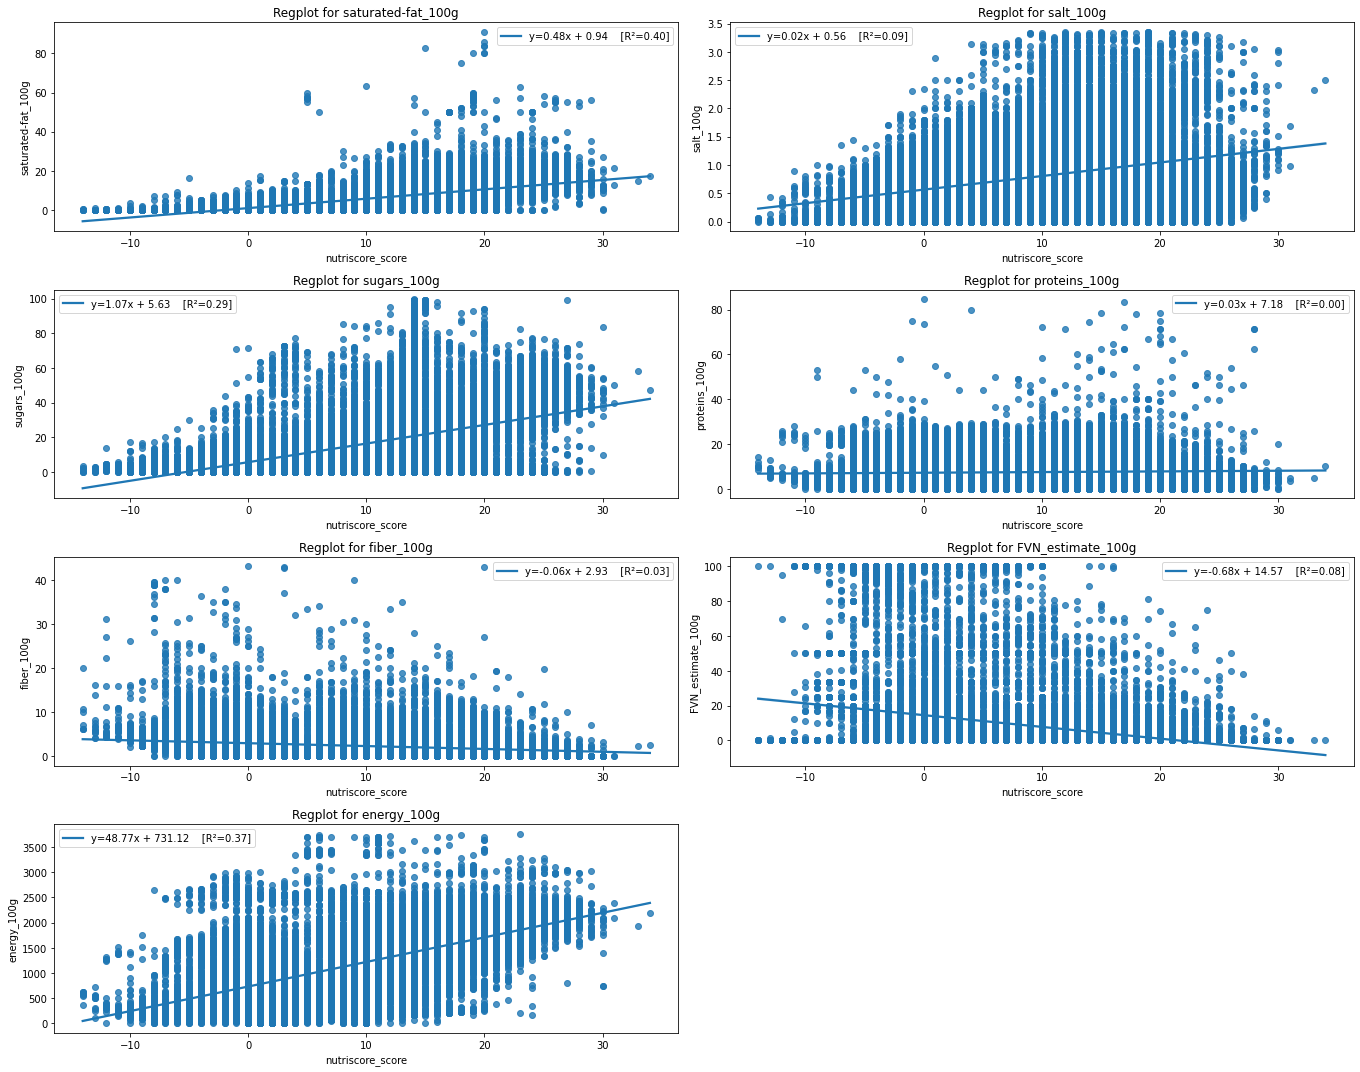

In [118]:
from scipy import stats

fig = plt.figure(figsize=(19,15))

for i, col in enumerate(columns_):
    plt.subplot(4,2,i+1)

    slope, intercept, r_value, pv, se = stats.linregress(data_sample['nutriscore_score'], data_sample[col])
    sns.regplot(x="nutriscore_score", y=col, data=data_sample, line_kws={'label':f"y={slope:.2f}x + {intercept:.2f}    [R²={r_value**2:.2f}]"})
    #sns.jointplot(x="nutriscore_score", y=col, data=data_clean.sample(frac=0.01), kind="reg")#, stat_func=r2)
    plt.title(f"Regplot for {col}")
    plt.legend()

fig.tight_layout()
plt.show()

> En regardant les coéfficients de déterminations R², on constate exactement les même tendances qu'avec les coefficients de Pearson et Spearman. On a une corrélation moyennement forte pour `saturated-fat_100g`, `energy_100g` et `sugars_100g`, une corrélation faible pour `salt_100g`, `FVN_estimate_100g` et `fiber_100g`, aucune corrélation pour `proteins_100g`.
>
> - `saturated-fat_100g`: **R² = 0.40** *[Pearson = 0.58 & Spearman = 0.64]*
> - `energy_100g`:        **R² = 0.37** *[Pearson = 0.55 & Spearman = 0.60]*
> - `sugars_100g`:        **R² = 0.29** *[Pearson = 0.43 & Spearman = 0.32]*
> - `salt_100g`:          **R² = 0.09** *[Pearson = 0.31 & Spearman = 0.31]*
> - `FVN_estimate_100g`:  **R² = 0.08** *[Pearson = -0.24 & Spearman = -0.19]*
> - `fiber_100g`:         **R² = 0.03** *[Pearson = -0.17 & Spearman = -0.21]*
> - `proteins_100g`:      **R² = 0.00** *[Pearson = 0.08 & Spearman = 0.08]*

> Même si l'on retrouve des tendances similaires à ce que l'on a observé avec `nutriscore_score`, on constate que les relations entre les indicateurs des nutriments et le `nutriscore_grade` sont encore une fois moins évidentes.

> A ce stade, il parait donc opportun de travailler sur la prédiction du `nutriscore_score` et de le convertir en `nutriscore_grade` plutôt que de directement chercher à prédire `nutriscore_grade`.

### Puis vérifions les indices de corrélation entre les variables numériques et nominales.
                                                                                   
Pour permettre de vérifier simplement la corrélation entre les variables numériques et les variables nominales, nous allons utiliser un LabelEncoder sur les colonnes nominales qui nous intéressent puis calculer à nouveau les corrélations linéaires et monotones.<br>(On pourrait aussi calculer $\eta^2$ à partir d'une ANOVA)

In [119]:
data_corr = data_clean.copy()

In [120]:
from sklearn.preprocessing import LabelEncoder

In [121]:
cats = ['pnns_groups_2', 'nutriscore_grade', 'nova_group']

for cat in cats:
    encoder=LabelEncoder()
    encoder.fit(data_corr[cat])
    data_corr[f"{cat}_enc"]=encoder.transform(data_corr[cat])

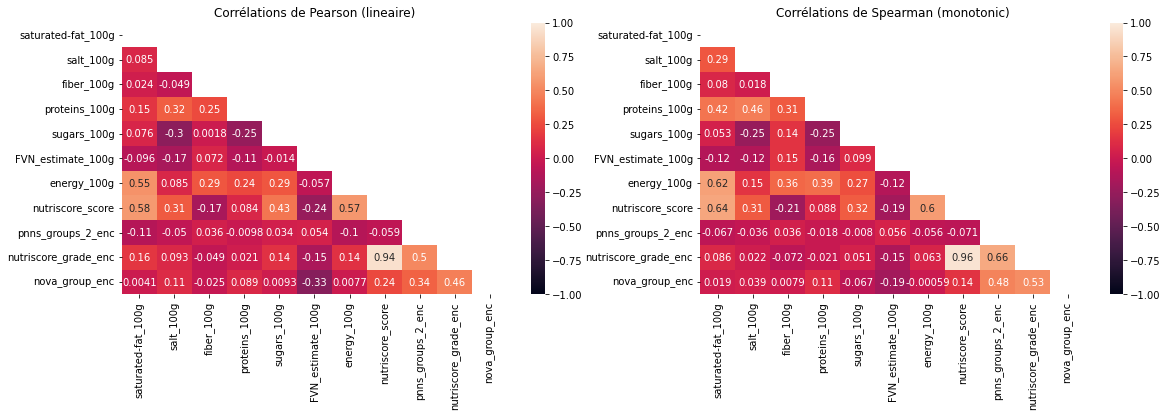

In [122]:
fig = plt.figure(figsize=(19,5))

plt.subplot(1,2,1)
corr= data_corr.corr(method="pearson")
matrix = np.triu(corr)
ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=matrix)
ax.set_title('Corrélations de Pearson (lineaire)')
ax.legend

plt.subplot(1,2,2)
corr= data_corr.corr(method="spearman")
matrix = np.triu(corr)
ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=matrix)
ax.set_title('Corrélations de Spearman (monotonic)')
#ax.set(yticklabels=[x[-22:] for x in data_corr.select_dtypes(include=np.number).columns])

plt.show()

> Comme attendu on constate une forte corrélation entre le `nutriscore_score` et `nutriscore_grade_enc`.
>
> On constate également plusieurs corrélations entre `nutriscore_grade_enc` et les divers indicateurs nutritionnels, mais elles sont nettement moins prononcées qu'avec `nutriscore_score`.
>
> Enfin, les deux autres variables nominales encodées `nova_group_enc` et `pnns_groups_2_enc` ne semblent pas particulièrement sensible aux variables des nutriments.
---

#### Vérifions les relations entre `nutriscore_grade` et les variables des nutriments

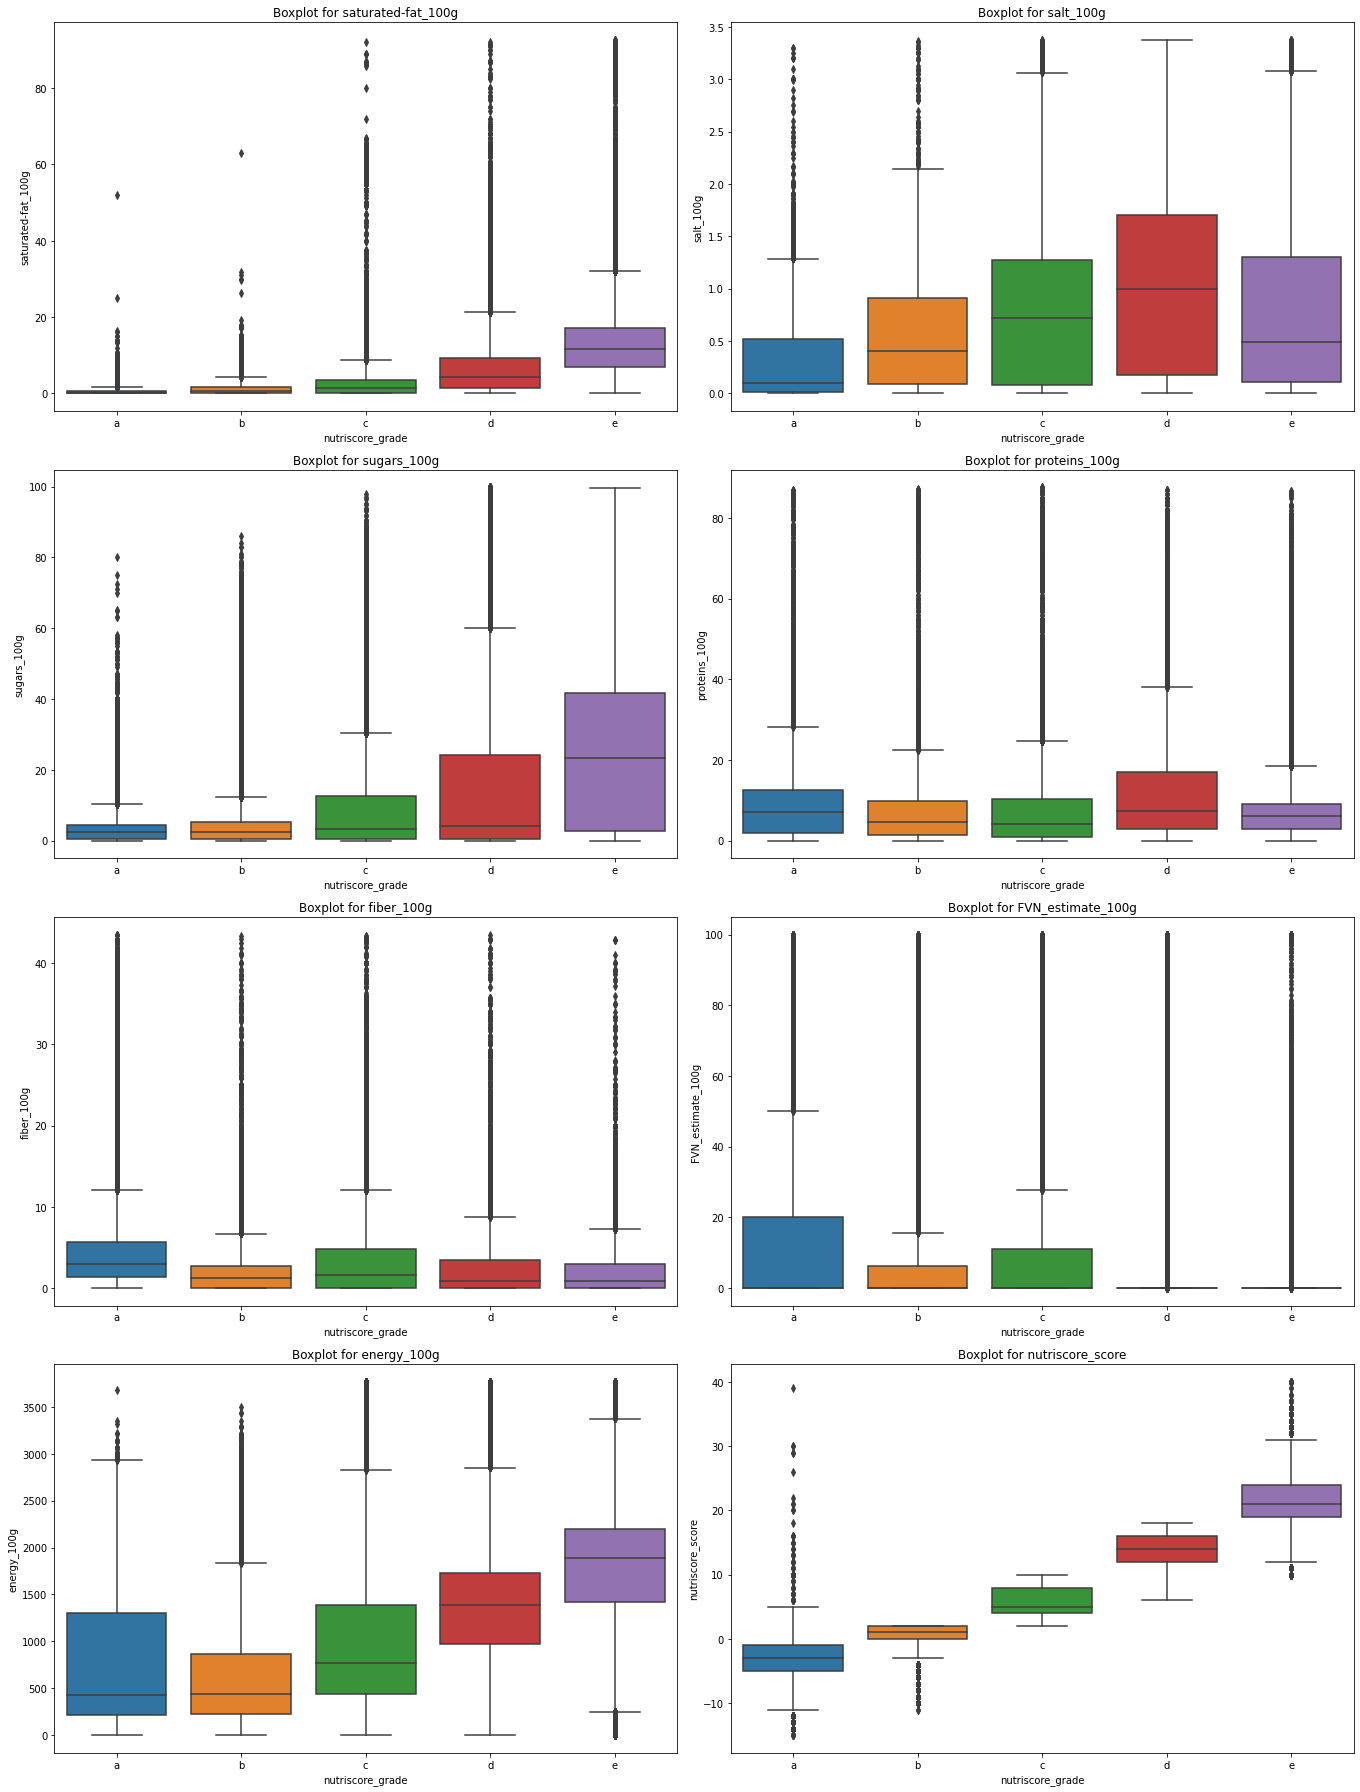

In [123]:
from scipy import stats

columns_ = ['saturated-fat_100g', 'salt_100g', 'sugars_100g', 'proteins_100g', 'fiber_100g', 'FVN_estimate_100g', 'energy_100g', 'nutriscore_score']

fig = plt.figure(figsize=(19,25))

for i, col in enumerate(columns_):
    plt.subplot(4,2,i+1)
    sns.boxplot(data=data_clean, x='nutriscore_grade', y=col, order='abcde')
    plt.title(f"Boxplot for {col}")

fig.tight_layout()
plt.show()

> Pour le boxplot `nutriscore_score` vs `nutriscore_grade` on perçoit immédiatement une relation forte.
>
> La documentation indique les plages suivantes pour les aliments:
> - [-15;-1] pour le **A**
> - [0;2] pour le **B**
> - [3;10] pour le **C**
> - [11;18] pour le **D**
> - [19;40] pour le **E**
>
> La documentation indique les plages suivantes pour les boissons:
> - Uniquement l'eau pour le **A**
> - [-15;1] pour le **B**
> - [2;5] pour le **C**
> - [6;9] pour le **D**
> - [10;40] pour le **E**
>
> On remarque des outliers, mais on constate que ces valeurs semblent majoritairement respectées.

> En revanche pour la relation de `nutriscore_grade` avec les autres indicateurs les tendances sont présentes, *(comme on vient de le voir avec les corrélation de Pearson et Spearman)* mais nettement moins prononcées qu'avec `nutriscore_score`.

### Ensuite vérifions les indices de corrélation entre les variables nominales. <a class="anchor" id="P03_correlation_nom"></a>

Pour ce faire, nous allons utiliser le test V de Cramer.<br>
C'est une mesure d'association entre deux variables nominales, qui est basée sur le Chi-squared de Pearson.<br>
Elle donne une valeur comprise entre 0 et +1 (inclus)
- 0 : il n'y a visiblement aucune relation entre les variables.
- 1 : il y a une relation parfaite entre les variables (on ne peut atteindre 1 que lorsque chaque variable est complètement déterminée par l'autre).

In [124]:
import scipy.stats as ss

def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

vars_ = ['nutriscore_grade', 'nova_group', 'pnns_groups_2']

corr = []
for v1 in vars_:
    corr2 = []
    for v2 in vars_:
        confusion_matrix = pd.crosstab(data[v1], data[v2])
        cramer_score = cramers_v(confusion_matrix.values)
        #print(f"{v1} / {v2} -> {cramer_score}")
        corr2.append(cramer_score)
    corr.append(corr2)
    
corr = pd.DataFrame(corr)
corr.index = corr.columns = vars_

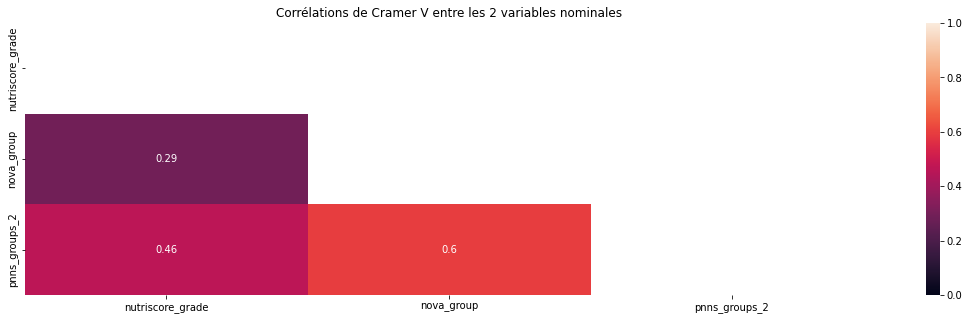

In [125]:
fig = plt.figure(figsize=(19,5))

matrix = np.triu(corr)
ax = sns.heatmap(corr, vmin=0, vmax=1, annot=True, mask=matrix)
ax.set_title('Corrélations de Cramer V entre les 2 variables nominales')

plt.show()

> Le `nutriscore_grade` n'est que peu corrélé au `nova_group`, mais on constate en revanche que ces deux systèmes de classifications sont assez corrélés aux catégories de produits `pnns_groups_2`.

### Regardons également les relations `pnns_groups_2` vs `nutriscore_score` et `nutriscore_grade`

#### Comment se répartissent les catégories `pnns_groups_2` sur les différents grade de `nutriscore_grade` ?

In [126]:
num_cats = 25
top_categories = list(data_clean['pnns_groups_2'].value_counts(dropna=True)[:num_cats].index)

#--- prepare data
#data_tmp = data_clean.copy()
#data_tmp['category'] = data_tmp['pnns_groups_2']
#data_tmp.loc[~data_tmp['pnns_groups_2'].isin(top_categories),'category'] = 'OTHERS'
#top_categories.append('OTHERS')

#--- select data
selection = data_clean.groupby(['nutriscore_grade', 'pnns_groups_2']).size().reset_index()
selection.rename(columns={0:'count'}, inplace=True)
data_graph = selection[selection['pnns_groups_2'].isin(top_categories)]

#--- graph
fig = px.bar(data_graph, 
             x="nutriscore_grade",
             y="count",
             color="pnns_groups_2",
             title=f"Répartition des produits des {num_cats} catégories principales dans les Nutri-grades",
             labels={'count': 'Nombre de produits', 'nutriscore_grade':'Nutri-grade', 'pnns_groups_2':'Categories'},
             category_orders={'nutriscore_grade': ['a','b','c','d','e']},
             height=700,
            )
fig.show()

> Le `grade A` semble contenir des **aliments bruts**; *légumes*, *céréales*, *fruits*, *viandes*, *poissons* et *produits laitiers*. Mais aussi **quelques produits transformés** comme des *plats-cuisinés* et *sucreries* qui sont plus surprenants.

> Le `grade B` semble contenir des **aliments bruts** et des **produits transformés**; *plats-cuisinés*, *produits-laitiers*, *viandes*, *poissons*, *céréales**, *pains*...

> Le `grade C` semble contenir des **produits bruts gras** et des **produits transformés**; *plats-cuisinés*, *huiles*, *sauces*, *biscuits & cakes*, *sucreries*, *viandes transformées* mais aussi quelques *viandes* et *poissons*...

> Le `grade D` semble contenir des **produits transformés gras / sucrés / salés**; *fromages*, *bicuits & cakes*, *sucreries*, *viandes transformées*, *poissons*, *sauces*, ...

> Le `grade E` semble contenir des **produits transformés gras / sucrés / salés** plus orientés encas; *biscuits & cakes*, *sucreries*, *viandes transformées*, *chocolats*, *boissons sucrées*...

#### Regardons à présent pour chacune de ces catégories `pnns_groups_2` leur répartition dans les `nutriscore_grade`

In [127]:
#--- select data
selection = data_clean.groupby(['nutriscore_grade', 'pnns_groups_2']).size().reset_index()
selection.rename(columns={0:'count'}, inplace=True)
data_graph = selection[selection['pnns_groups_2'].isin(top_categories)]

#--- graph
fig = px.bar(data_graph, 
             x="pnns_groups_2",
             y="count",
             color="nutriscore_grade",
             title=f"Répartition des Nutri-grades dans les {num_cats} catégories principales",
             labels={'count': 'Nombre de produits', 'nutriscore_grade':'Nutri-grade', 'pnns_groups_2':'Categories'},
             category_orders={'pnns_groups_2': top_categories},
             height=600,
            )
fig.show()

Si l'on prend quelques catégories emblématiques, on constate que le classement est assez cohérant avec ce que l'on à découvert plus haut (tendances à monter en grade avec le sucre, le gras, le sel...)

> Les `Vegetables` *(légumes)* sont essentiellement classés `A`.

> Les `Milk and yogurt` *(lait & yahourts)* sont essentiellement classés `B` et `C`

> Les `Sweets` *(sucreries)* sont essentiellement classés `D` et `E`.

La colonne `Alcoholic beverages` semble vide, mais c'est parcque cette catégorie a peu de données `nutriscore_grade`.

In [128]:
data_clean[ (data_clean.pnns_groups_2 == 'Alcoholic beverages') & (data_clean.nutriscore_grade.notnull()) ].shape[0]

55

In [129]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
#--- graph
fig = px.bar(data_graph, 
             x="product_name",
             y="count",
             color="nutriscore_grade",
             title=f"Répartition des Nutri-grades, dans les {num_cats} nom de produits les plus fréquents",
             labels={'count': 'Nombre de produits', 'nutriscore_grade':'Nutri-grade', 'main_category':'Categories'},
             category_orders={'product_name': top_names},
             height=600,
            )
fig.show()

In [ ]:
sns.kdeplot(
   data=data_clean, x="sugars_100g", hue="nutriscore_grade",
   fill=True, common_norm=False,
   alpha=.5, linewidth=0,
)

In [ ]:
sns.pairplot(data_clean[['nutriscore_score','nutriscore_grade']], hue="nutriscore_grade")

In [ ]:
sns.pairplot(data_clean[['sugars_100g', 'fiber_100g','proteins_100g','nutriscore_grade']].sample(frac=0.1), hue="nutriscore_grade")

In [ ]:
sns.pairplot(data_clean[['nutriscore_score','nutriscore_grade','sugars_100g']].sample(frac=0.1), hue="nutriscore_grade")

In [ ]:
sns.boxplot(data=dataframe,
            x=categorical_column, 
            y=col,
            order=order_values,
            showmeans=True,
            ax=axes[int(np.floor(i / num_cols)), i % num_cols],
        )

In [ ]:
figure = plt.figure(figsize=(15,5))

dt = data_clean[col_name]

    fig = px.bar(dt, y=col_name, 
             #width=900,
             height=500,
             color=col_name, 
             title=title,
             labels={
                "fill_rate": ylabel,
                "index": "",
                },
             text_auto=showtext,
             template='ggplot2',
             #hover_data={'Fraction':':.2f'},
            )
    fig.update_coloraxes(showscale=showscale)
    fig.update_xaxes(tickangle = -45)
    fig.show()

In [ ]:
fig = px.scatter_matrix(data_clean.sample(frac=.01),
    dimensions=[
        'fiber_100g',
        'proteins_100g',
        'nutrition-score-fr_100g',
    ],
    color="nutrition_grade_fr", 
    symbol="nutrition_grade_fr",
    category_orders={'nutrition_grade_fr': NUTRITION_GRADES},
    hover_data=['product_name', 'main_category'],
    opacity=.2,
    width=1200,
    height=1200,
    title="Distribution of products over variables decreasing the Nutri-Score",
)
fig.update_traces(
    showupperhalf=False,
    diagonal_visible=False,
)
fig.show()

# 5. Nettoyage & imputation des données <a class="anchor" id="P05"></a>

## Supprimons les doublons

In [ ]:
data_duplicate = data.copy()

#### Commençons par supprimer les produits en double sur la base du code-barre

In [ ]:
duplicated = data_duplicate.code.duplicated(keep='first')
duplicated.sum()

In [ ]:
data_duplicate.drop_duplicates(subset=['code'], inplace=True) 

> Nous avons donc supprimé 21 produits en double.

#### Ensuite vérifions si il y a des lignes similaires en excluant le code-barre

In [ ]:
cols_without_code = list(data_duplicate.columns)
cols_without_code.remove("code")

In [ ]:
duplicated = data_duplicate[cols_without_code].duplicated(keep='first')
duplicated.sum()

> Il n'y a visiblement pasd'autres doublons.

#### Reportons les modifications sur le data_clean

In [ ]:
data_clean = data_duplicate.copy()
data_clean.shape

## Supprimons les valeurs aberrantes

In [ ]:
data_clean.describe().T

Comme on peut le constater, un certain nombre de colonnes ont des valeurs étonnantes...

> `serving_quantity`
> 
> le maximum est bien au delà du troisième quartile, et l'écart type est énorme...

> Les colonnes `*_100g`
>
> le maximum dépasse les 100g et ce n'est pas possible *(car d'après la notice **"fields that end with _100g correspond to the amount of a nutriment (in g, or kJ for energy) for 100 g or 100 ml of product"** et donc il ne peut y avoir de valeurs > 100)*
>
>> Pour `cholesterol_100g` le maximum semble être à **3.1g** (3100mg) pour 100g /// Cervelle de veau cuite
>
>> Pour `fat_100g` le maximum semble être à **100g** pour 100g /// Huile d'avocat
>
>> Pour `saturated-fat_100g` le maximum semble être à **92.6** pour 100g /// Pain de friture (pas l'huile ?)
>
>> Pour `proteins_100g` le maximum semble être à **87.6g** pour 100g /// Gélatine alimentaire
>
>> Pour `sugars_100g` le maximum semble être à **99.8g** pour 100g /// Fructose
>
>> Pour `carbohydrates_100g` le maximum semble être à **99.8g** pour 100g /// Fructose
>
>> Pour `sodium_100g` le maximum semble être à **39.1g** (39100 mg)pour 100g /// sel blanc non iodé non fluoré 
>
>> Pour `salt_100g` le maximum semble être à **39.1g** (39100 mg)pour 100g /// sel blanc non iodé non fluoré 
>
>> Pour `iron_100g` le maximum semble être à **0,0064g** (6.4 mg) pour 100g /// Boudin noir
>
>> Pour `calcium_100g` le maximum semble être à **2g** (2000 mg) pour 100g /// Meloukhia en poudre 
>
>> Pour `fiber_100g` le maximum semble être à **43.5g** pour 100g /// Cannelle
>
>> Pour `energy-kcal_100g` le maximum semble être à **900 kcal** pour 100g /// Huile d'avocat
>
>> Pour `energy-kj_100g` le maximum semble être à **3765.6 kcal** pour 100g /// Huile d'avocat

> `carbohydrates_100g`, `sugars_100g`, `fiber_100g`, `proteins_100g`, `nutriscore_score`, `ecoscore_score`
>
> le minimum est sous 0, ce qui ne semble pas cohérent avec l'intitulé de ces colonnes.

In [ ]:
data_duplicate = data.copy()

#### Commençons par supprimer les produits en double sur la base du code-barre

In [ ]:
duplicated = data_duplicate.code.duplicated(keep='first')
duplicated.sum()

In [ ]:
data_duplicate.drop_duplicates(subset=['code'], inplace=True) 

> Nous avons donc supprimé 21 produits en double.

#### Ensuite vérifions si il y a des lignes similaires en excluant le code-barre

In [ ]:
cols_without_code = list(data_duplicate.columns)
cols_without_code.remove("code")

In [ ]:
duplicated = data_duplicate[cols_without_code].duplicated(keep='first')
duplicated.sum()

> Il n'y a visiblement pasd'autres doublons.

#### Reportons les modifications sur le data_clean

In [ ]:
data_clean = data_duplicate.copy()
data_clean.shape

## TODO

> mixer la suppressions sur les valeurs réelles quand elles sont connues et les valeurs IQR dans le cas contraire  ?

le taux de sel ~= 2.54 * taux de sodium

donc normalement salt_100g = 2.54 * sodium_100g


#### Éléments défavorables au score

- Apport calorique pour cent grammes. **->** `energy-kcal_100g` ou `energy-kj_100g` ou `energy_100g`
- Teneur en sucre. **->** `sugars_100g` ou `carbohydrates_100g`
- Teneur en graisses saturées. **->** `saturated-fat_100g`
- Teneur en sel. **->** `salt_100g` *(ou `sodium_100g` car 40% de sodium dans le sel + 60% de chlorure)*

> `energy_100g`, `sugars_100g`, `saturated-fat_100g`, `salt_100g`

#### Éléments favorables au score

- Teneur en fruits, légumes, légumineuses (dont les légumes secs), oléagineux, huiles de colza, de noix et d'olive. **->** `fruits-vegetables-nuts-estimate-from-ingredients_100g` **?** ou `fruits-vegetables-nuts_100g`
- Teneur en fibres. **->** `fiber_100g`
- Teneur en protéines. **->** `proteins_100g`

> `fruits-vegetables-nuts-estimate-from-ingredients_100g`, `fiber_100g`, `proteins_100g`

# Notes & Essais

In [ ]:
data.states

In [ ]:
data.states.iat[0]

In [ ]:
data.states_fr

In [ ]:
data_split = data_clean.copy()
data_split['split_name'] = data_split['product_name']

mask = data_split['product_name'].value_counts()
data_split.loc[data_split['product_name'].isin(mask.index[mask<=1.0]),'split_name'] = '1 product'